In [5]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('../../..')
sys.path.append('../../../lib/src/')
sys.path.append('../../../TopographicVAE-master')
import torch
from torch import nn
import torch.nn.functional as F
import os
from itertools import islice
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, Encoder_ColorMNIST,Decoder_ColorMNIST
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling

from tvae.data.mnist import DualTransformPreprocessor, PersepctivePreprocessor, Preprocessor
from tvae.utils.logging import get_dirs


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(grid, color=True):
    NUM_SEQ = grid.shape[0]
    NUM_FRAMES = grid.shape[1]

    fig, axs = plt.subplots(NUM_SEQ, NUM_FRAMES, figsize=(NUM_FRAMES, NUM_SEQ))
    if NUM_SEQ == 1:
        axs = axs[None, :]
    for i in range(NUM_SEQ):
        for j in range(NUM_FRAMES):
            axs[i, j].imshow(grid[i, j].cpu().detach().permute(1, 2, 0), cmap='gray' if not color else None)
            axs[i, j].axis('off')
    
    plt.show()

def extract_dataset(loader):
    dataset = []

    for data, label in loader:
        data = data.squeeze(2,3) #(32, 18, 3, 28, 28)
        dataset.append(data)
    
    dataset = torch.cat(dataset, 0)
    return dataset

%reload_ext autoreload
%autoreload 2

!nvidia-smi

Tue Jul 30 15:04:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   38C    P8             10W /   70W |     225MiB /  12282MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

torch.Size([8000, 8, 1, 28, 28])
torch.Size([4000, 8, 1, 28, 28])
torch.Size([10, 8, 1, 28, 28])


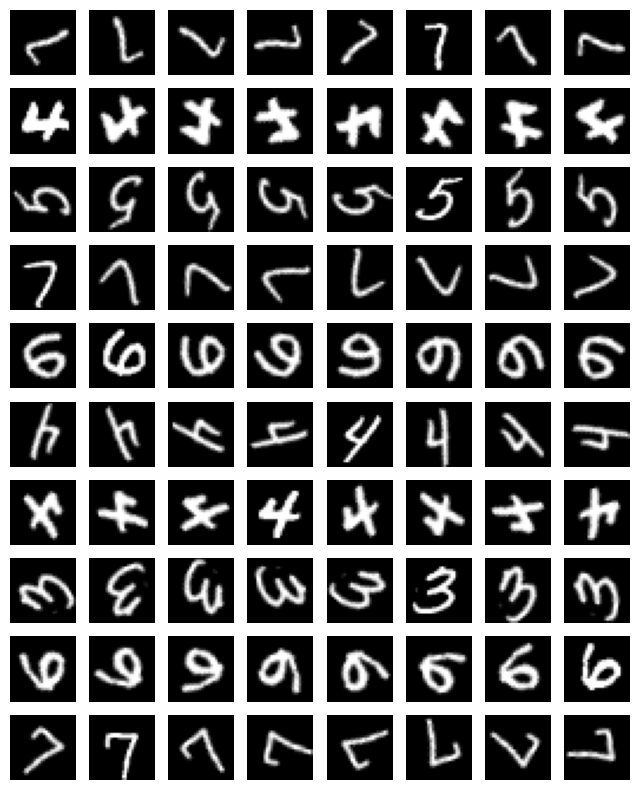

In [13]:
#ROTCOLOR MNIST
# config = {
#     'wandb_on': False,
#     'lr': 1e-4,
#     'momentum': 0.9,
#     ########################
#     'batch_size': 32,
#     ########################
#     'max_epochs': 100,
#     'eval_epochs': 5,
#     'dataset': 'MNIST',
#     'train_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'test_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340', 
#     'train_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'test_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'train_scale_set': '1.0',
#     'test_scale_set': '1.0',
#     'pct_val': 0.2,
#     'random_crop': 28,
#     'seed': 1,
#     'n_caps': 18,
#     'cap_dim': 18,
#     'n_transforms': 18,
#     'mu_init': 30.0,
#     'n_off_diag': 1,
#     'group_kernel': (13, 13, 1),
#     'train_eq_loss': False,
#     'n_is_samples': 10
#     }

config = {
    'wandb_on': False,
    'lr': 1e-4,
    'momentum': 0.9,
    ########################
    'batch_size': 32,
    ########################
    'max_epochs': 100,
    'eval_epochs': 5,
    'dataset': 'MNIST',
    'train_angle_set': '0 40 80 120 200 240 280 320',
    'test_angle_set': '0 40 80 120 200 240 280 320', 
    'train_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
    'test_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
    'train_scale_set': '1.0',
    'test_scale_set': '1.0',
    'pct_val': 0.2,
    'random_crop': 28,
    'seed': 1,
    'n_caps': 18,
    'cap_dim': 18,
    'n_transforms': 12,
    'mu_init': 30.0,
    'n_off_diag': 1,
    'group_kernel': (13, 13, 1),
    'train_eq_loss': False,
    'n_is_samples': 10
    }

name = 'TVAE_Rotation&Color-MNIST_L=13/36_K=3'

config['savedir'], config['data_dir'], config['wandb_dir'] = get_dirs()

savepath = os.path.join(config['savedir'], name)
preprocessor = Preprocessor(config, transform = 'rotation', coloring = False)
train_loader, val_loader, test_loader = preprocessor.get_dataloaders(batch_size=config['batch_size'])

train_loader = list(islice(train_loader, 250))
val_loader = list(islice(val_loader, 125))

train_data = extract_dataset(train_loader)
eval_data = extract_dataset(val_loader)
print(train_data.shape)
print(eval_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)


x = next(iter(train_loader))
imgs = x[0].squeeze(2, 3)[:10]
print(imgs.shape)
plot_sequence(imgs, color=False)

In [11]:
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-07-29_16-54-10/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_2/checkpoints/epoch=49-step=1600.ckpt'

device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data.reshape(-1,3,28,28)[torch.randint(low = 0, high = train_data.shape[0], size = (30000,))], verbose = True, T_multiplier=5, device = device, addStdNorm=True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

h,w = 28, 28
input_dim = (3, h, w)
f = 14 #subsampling factor
latent_dim = 3* (h // f) * (w // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 14 is empty! self.labels_[self.medoid_indices_[14]] may not be labeled with its corresponding cluster (14).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 16 is empty! self.labels_[self.medoid_indices_[16]] may not be labeled with its corresponding cluster (16).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 22 is empty! self.labels_[self.medoid_indices_[22]] may not be labeled with its corresponding cluster (22).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 23 is empty! self.labels_[self.medoid_indices_[23]] may not be la

Finding temperature
Best temperature found:  1.3060053586959839
Building metric
Increasing T by  5
Adding std normal to centroids and var
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [14]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 28, 28),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=100,
        learning_rate=5*1e-4,
        batch_size=128,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cuda'
encoder = Encoder_ColorMNIST(model_config).to(device)
decoder = Decoder_ColorMNIST(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
temperature = 1


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)

lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                 precomputed_zT_samples=None, verbose = True, temp = temperature)

Diffusion time steps  [995 853 711 569 427 285 143   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 5.4e+06
Number of total parameters: 1.3e+07


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


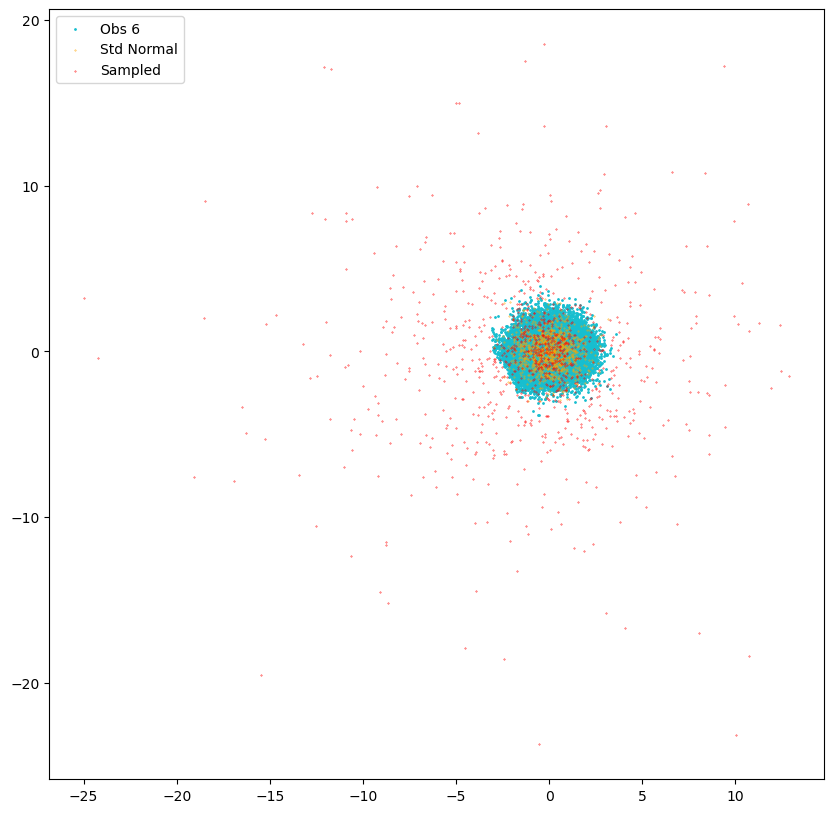

In [14]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 7
DISPLAYED_OBS =  [6]
PROJECTING_OBS = [6]
NUM_POINTS = 1000
#########

train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0]*train_dataset.data.shape[1])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

#all_z_pca = pca.transform(all_z.cpu().detach().numpy())
#p_pca  = pca.transform(p.cpu().detach().numpy())
colors = plt.get_cmap('tab10', NUM_OBS)




plt.figure(figsize=(10, 10))
for i in DISPLAYED_OBS:
    indices = [k % NUM_OBS == i for k in range(train_embeddings.shape[0])]
    plt.scatter(train_pca[indices, 0], train_pca[indices, 1], label=f'Obs {i}', s= 1, color = colors(i))


check = torch.randn(NUM_POINTS, 12)
check_pca = pca.transform(check.detach().numpy())

start = check.reshape(NUM_POINTS, model.c, model.h, model.w).cuda()
sampled, _, _ = lldm.ddim_sampler.sample(shape=(NUM_POINTS, model.c, model.h, model.w), x_last = start, cond=None, temperature= lldm.temperature)
sampled = sampled.reshape(NUM_POINTS, lldm.latent_dim)
sampled_pca = pca.transform(sampled.cpu().detach().numpy())

plt.scatter(check_pca[:, 0], check_pca[:, 1], s = 0.1, label='Std Normal', c = 'orange')
plt.scatter(sampled_pca[:, 0], sampled_pca[:, 1], s = 0.1, label='Sampled', c = 'red')


plt.legend()
plt.show()

In [15]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="rotColorMNIST_LLDM", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meilame-tayebjee. Use `wandb login --relogin` to force relogin


In [53]:
optimizer = torch.optim.Adam(lldm.parameters(), lr=1e-3)

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
trainer = BaseTrainer(
            model=lldm,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )

In [58]:
# for p in lldm.parameters():
#     p.requires_grad = True
# for p in lldm.pretrained_vae.parameters():
#     p.requires_grad = False
# for p in lldm.pretrained_ldm.parameters():
#     p.requires_grad = False
lldm = lldm.to('cuda')
lldm = lldm.train()
trainer.train()

Model passed sanity check !

Created lldm/LLDM_IAF_training_2024-07-30_13-48-20. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   38.375230  98.400833    3.0
1   34.053837  -1.769734    3.0
2   36.135210   3.587672    8.0
3   38.497280  -1.865523    3.0
4   36.106915   2.674838    4.0
5   37.409787   3.133867    4.0
6   35.509004   4.203821    9.0
7   34.807635   1.584879    9.0
8   36.428331   1.326396    5.0
9   35.168533   3.525074   11.0
10  35.251241   1.811267    5.0
11  34.944582   3.949201    5.0
12  35.664640  -1.352686    2.0
13  36.100404   1.449266    5.0
14  36.197995   1.658697    9.0
15  37.256016   0.217807    4.0
16  39.749887   4.911093    6.0
17  44.234141   3.384653    3.0


Eval of epoch 1/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.2348
Eval loss: 37.3549
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   37.825522  99.810115    5.0
1   35.853544   1.089702    4.0
2   36.760682   2.617305   11.0
3   35.869700   4.468475    6.0
4   36.119286   2.588153    2.0
5   34.574320   4.049758    3.0
6   35.894783   3.321916    6.0
7   36.424732   4.872361    7.0
8   35.741295   3.103778    6.0
9   34.463621   2.858552    4.0
10  33.487353   6.076607    6.0
11  34.906012   2.798012    3.0
12  33.963196   4.121243    9.0
13  35.467314   2.613267    3.0
14  34.969801   3.752155    4.0
15  36.165414   3.423637    5.0
16  38.056248   3.572107    6.0
17  39.424117   4.270844    5.0


Eval of epoch 2/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.2277
Eval loss: 38.6212
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss    reg_loss  count
0   37.118787  108.782307    5.0
1   35.011284    3.677016    7.0
2   34.563551    1.044867    5.0
3   34.260265    2.454578    5.0
4   33.652870    2.815877    8.0
5   33.683294    4.318650    5.0
6   34.004681    3.144277    8.0
7   34.029457    2.798923    3.0
8   33.914793    4.067983    5.0
9   33.711300    4.180242    7.0
10  34.154838    4.699411    5.0
11  33.952806    4.297944    6.0
12  33.432907    3.675232    4.0
13  35.684540    4.238533    6.0
14  36.191738    3.585919    4.0
15  37.329079    5.181897    1.0
16  39.112055    4.180207    3.0
17  41.347093    4.223029    8.0


Eval of epoch 3/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.1786
Eval loss: 34.6717
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss    reg_loss  count
0   38.123497  116.342377    1.0
1   35.099957    0.876995    8.0
2   33.850332    1.499059    9.0
3   33.868158    0.484015    6.0
4   33.284382    1.353945    5.0
5   33.780249    0.694400    7.0
6   32.520956    1.790735    6.0
7   32.919362    1.511148    8.0
8   33.188210    1.016554    5.0
9   32.773261    0.976987    3.0
10  32.413401    0.645440    7.0
11  33.208967    0.952387    5.0
12  33.728844   -0.241517    2.0
13  34.670530    1.642722    5.0
14  35.854240    1.189666    6.0
15  36.897650    1.850973    2.0
16  38.708384    0.836869    3.0
17  40.869592    0.900305    7.0


Eval of epoch 4/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.8016
Eval loss: 35.0422
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   36.141030  97.860925    5.0
1   34.014736   0.011172   14.0
2   34.061710  -0.696351    4.0
3   33.658223  -0.489081    6.0
4   33.177631  -0.290105    7.0
5   34.384333  -1.221859    2.0
6   33.182933   0.136896   10.0
7   32.483713   0.460715    4.0
8   33.713196  -0.443836    5.0
9   33.860056   0.595684    5.0
10  32.928894   0.557983    3.0
11  32.970162   0.088329    5.0
12  34.186742   0.393245    6.0
13  34.477497  -0.158024    7.0
14  35.275578   0.245925    3.0
15  37.786851   0.570020    4.0
16  39.438171   0.623014    1.0
17  40.619678  -1.011234    4.0


Eval of epoch 5/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.0057
Eval loss: 36.9182
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   35.942469  80.739902    8.0
1   34.824771  -1.013003    6.0
2   33.960956  -0.920685    4.0
3   33.716559  -0.180457    5.0
4   34.320024  -0.729964    4.0
5   33.275020  -0.666251    7.0
6   32.502071  -0.905959    4.0
7   32.993026  -0.417733    5.0
8   33.056908  -0.505695    3.0
9   33.077232  -1.043104    7.0
10  32.317684  -1.320577    4.0
11  33.287024  -0.744471    5.0
12  33.952958  -0.239229    5.0
13  35.435755  -0.207023    3.0
14  36.131864  -0.248089    4.0
15  36.769538  -0.638328    6.0
16  39.393873  -0.201634    9.0
17  41.926711  -0.541349    6.0


Eval of epoch 6/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.6178
Eval loss: 35.4363
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.741144  72.623270   10.0
1   33.948518  -1.054557    3.0
2   34.650523  -1.269076    5.0
3   33.581318  -1.094171    6.0
4   33.599125  -1.422110    5.0
5   33.353255  -0.741118    4.0
6   32.972227  -1.331199    6.0
7   33.148801  -1.275476    7.0
8   32.286433  -1.657207    3.0
9   32.499208  -1.390026    5.0
10  32.513962  -1.180612    8.0
11  33.244914  -1.297355    7.0
12  33.850646  -1.552820    3.0
13  33.882944  -1.253386    4.0
14  35.734566  -1.572563    4.0
15  36.713175  -1.128455    6.0
16  38.453229  -1.453306    5.0
17  40.703373  -1.280580    4.0


Eval of epoch 7/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.2819
Eval loss: 35.1011
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   36.581514  72.885690    4.0
1   33.899198  -1.376320    4.0
2   33.923160  -1.047154    8.0
3   33.600648  -1.289113    5.0
4   32.853867  -1.284011    3.0
5   33.867956  -1.243346    4.0
6   33.673938  -1.336809    4.0
7   32.652161  -0.812523    2.0
8   33.120972  -1.105723    4.0
9   32.150984  -1.053691    4.0
10  33.025352  -1.537512    7.0
11  34.547092  -1.646988    6.0
12  35.078826  -1.167158    4.0
13  34.103532  -1.160380    8.0
14  34.109762  -1.148729    4.0
15  35.996317  -1.254954    7.0
16  37.382960  -1.360394    8.0
17  38.874972  -1.364756    9.0


Eval of epoch 8/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.165
Eval loss: 36.4739
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   36.750465  91.640738    6.0
1   34.748149  -1.536254    6.0
2   33.345627  -1.428202    3.0
3   32.677718  -1.180581    6.0
4   33.947009  -1.224733    8.0
5   33.550454  -1.367806    3.0
6   33.971653  -1.595758    9.0
7   32.868480  -1.467042    4.0
8   33.534694  -1.510644    4.0
9   33.195900  -0.892160    2.0
10  32.979255  -1.307581    7.0
11  32.971958  -1.619849    5.0
12  33.318619  -1.206768    2.0
13  33.942117  -1.576179    4.0
14  34.653710  -1.426423   12.0
15  34.931315  -1.466288    6.0
16  37.421164  -1.206509    3.0
17  39.405514  -1.561148    5.0


Eval of epoch 9/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.6633
Eval loss: 36.2082
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   35.998761  91.846681    7.0
1   33.791285  -1.488273    6.0
2   33.492432  -1.405072    3.0
3   33.371339  -1.688526    4.0
4   32.756843  -1.663084    7.0
5   33.408337  -1.529279    5.0
6   33.044036  -1.643939    4.0
7   32.848682  -1.679797    7.0
8   32.890854  -1.666818    8.0
9   32.245863  -1.635281    5.0
10  32.055171  -1.695903    7.0
11  32.719282  -1.604498    4.0
12  32.974033  -1.461061    6.0
13  34.397586  -1.518648    4.0
14  34.693478  -1.641601    5.0
15  35.178940  -1.670507    4.0
16  37.455196  -1.686740    5.0
17  39.681984  -1.348819    4.0


Eval of epoch 10/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.3515
Eval loss: 35.9405
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.812290  77.230577   10.0
1   33.568413  -1.756370    7.0
2   33.221268  -1.744153    7.0
3   34.201363  -1.861493    1.0
4   33.373919  -1.571645    6.0
5   32.730504  -1.823067    3.0
6   32.624363  -1.825297    9.0
7   33.263567  -1.686618    7.0
8   31.978962  -1.691644    8.0
9   32.635502  -1.570070    4.0
10  33.067285  -1.768570    4.0
11  32.920102  -1.783882    7.0
12  32.727477  -1.812294    4.0
13  34.175809  -1.816675    5.0
14  35.258169  -1.683811    2.0
15  37.574917  -1.847219    2.0
16  37.432755  -1.856369    4.0
17  41.339434  -1.862647    5.0


Eval of epoch 11/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.9569
Eval loss: 34.4302
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.930617  76.278788    3.0
1   33.536165  -1.735718    9.0
2   32.374422  -1.340679    6.0
3   33.097503  -1.497978    7.0
4   32.920766  -1.462191    9.0
5   32.029003  -1.445216    5.0
6   32.463816  -1.684063    4.0
7   33.116787  -1.708958    4.0
8   32.201170  -1.325937    7.0
9   32.889401  -1.761751    3.0
10  32.562629  -1.520521   10.0
11  33.312536  -1.728193    7.0
12  33.391151  -1.882578    2.0
13  33.889355  -1.841080    3.0
14  34.938457  -1.750530    4.0
15  36.929466  -1.833464    3.0
16  38.242559  -1.837604    8.0
17  43.179001  -1.266583    1.0


Eval of epoch 12/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.5993
Eval loss: 36.0606
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.519628  76.509770    5.0
1   33.538860  -1.725475    6.0
2   34.183583  -1.800178    5.0
3   34.161410  -1.614479    3.0
4   32.688236  -1.900202    2.0
5   33.067508  -1.867154    5.0
6   33.261371  -1.621977    3.0
7   32.831531  -1.798863    9.0
8   32.263768  -1.146830    4.0
9   32.329042  -1.068766    7.0
10  32.821892  -1.361102    4.0
11  32.622977  -1.836947    3.0
12  33.078533  -1.573313    8.0
13  34.557050  -1.829434    7.0
14  35.582506  -1.447459    6.0
15  36.120551  -1.604266    6.0
16  36.694290  -1.593561    6.0
17  39.315582  -1.852124    6.0


Eval of epoch 13/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.0309
Eval loss: 35.1629
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   35.844712  93.799540    4.0
1   33.868003  -1.219302   12.0
2         NaN        NaN    0.0
3   31.615216  -0.999711    3.0
4   31.995317  -1.503528    5.0
5   32.925594  -1.517506    7.0
6   32.093424  -1.216585    6.0
7   32.416595  -1.384545    8.0
8   32.378539  -1.351031    3.0
9   32.446938  -1.637230    3.0
10  31.950105  -1.510329    8.0
11  32.048156  -1.330237   10.0
12  33.541978  -1.423894    4.0
13  33.777620  -1.372159    5.0
14  34.775484  -1.696871    5.0
15  36.081184  -1.904148    1.0
16  38.740822  -1.397741    7.0
17  41.349342  -1.184387    4.0


Eval of epoch 14/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.8378
Eval loss: 34.0031
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   32.792698  76.157364    1.0
1   32.958411  -1.818490    5.0
2   33.799027  -1.893022    7.0
3   33.203938  -1.350169    5.0
4   33.570594  -1.835429    7.0
5   32.417118  -1.787619    2.0
6   32.832530  -1.570033    4.0
7   32.565582  -1.789815    6.0
8   32.325191  -1.842548    1.0
9   32.621305  -1.610992    6.0
10  33.031353  -1.730932    8.0
11  32.233297  -1.683150    7.0
12  32.878373  -1.875414    4.0
13  33.258877  -1.698798    8.0
14  34.389128  -1.821930    9.0
15  36.652610  -1.816761    4.0
16  37.922870  -1.632212    4.0
17  38.547335  -1.766704    7.0


Eval of epoch 15/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.5615
Eval loss: 35.3294
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   35.455058  84.483530   11.0
1   34.195257  -1.549387    4.0
2   33.485296  -1.723806    4.0
3   35.964931  -2.000000    1.0
4   33.944756  -1.768791    4.0
5   33.887048  -1.348435    5.0
6   32.837360  -1.441500    5.0
7   32.590060  -1.651937    6.0
8   33.302591  -1.769303    8.0
9   33.199913  -0.794876    1.0
10  32.987813  -1.525655    7.0
11  33.199406  -1.534208    7.0
12  32.768960  -1.756670    4.0
13  34.043176  -1.591119    5.0
14  34.613563  -1.659938   10.0
15  35.424149  -1.583541    6.0
16  37.418420  -1.551510    5.0
17  38.630402  -1.871793    2.0


Eval of epoch 16/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.1463
Eval loss: 35.8072
--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   37.146009  67.387014    4.0
1   34.319073  -1.887255    6.0
2   33.142256  -1.725829    5.0
3   33.459144  -1.799332    7.0
4   32.972259  -1.604515    4.0
5   34.053492  -1.788376    6.0
6   33.908499  -1.805137    4.0
7   33.814728  -1.872348    7.0
8   32.897456  -1.786672    7.0
9   33.000828  -1.667588    2.0
10  33.237226  -1.892190    7.0
11  34.153487  -1.937139    5.0
12  33.123835  -1.977698    4.0
13  34.277691  -1.732224    3.0
14  35.065546  -1.843400    4.0
15  35.847392  -1.919100   10.0
16  37.979594  -1.668951    4.0
17  39.573039  -1.779412    6.0


Eval of epoch 17/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.3019
Eval loss: 34.0124
--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.626347  79.938834    5.0
1   34.342368  -1.761441    5.0
2   32.849757  -1.418136    8.0
3   32.488108  -1.324623    3.0
4   33.536563  -1.517329    6.0
5   32.563449  -1.460447    6.0
6   32.461349  -1.530360    1.0
7   32.462334  -1.426702    8.0
8   32.098613  -1.734349    5.0
9   32.964151  -1.471232    6.0
10  32.807622  -1.525195    4.0
11  33.033280  -1.617399    9.0
12  34.365234  -1.337522    4.0
13  34.059938  -1.647841    3.0
14  34.647018  -1.815225    5.0
15  35.229632  -1.839865    6.0
16  37.032604  -1.760611    6.0
17  40.440441  -1.689809    5.0


Eval of epoch 18/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.7994
Eval loss: 34.513
--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.917678  82.809199    3.0
1   33.318910  -1.814406    3.0
2   33.330153  -1.633853    4.0
3   32.578384  -1.614157    7.0
4   33.103460  -1.685583   11.0
5   32.515878  -1.680238    4.0
6   32.372004  -1.678296    7.0
7   32.341667  -1.301112    7.0
8   32.207419  -1.583032    5.0
9   31.782759  -1.750346    4.0
10  32.725193  -1.698447    4.0
11  32.000456  -1.755307    6.0
12  33.052802  -1.445018    7.0
13  33.407770  -1.883805    3.0
14  34.238585  -1.713252    5.0
15  36.170930  -1.742049    3.0
16  37.880612  -1.749841    4.0
17  40.183547  -1.664505    8.0


Eval of epoch 19/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.708
Eval loss: 35.6021
--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   35.133053  93.823346    6.0
1   33.702447  -1.053439    6.0
2   34.070873  -1.629088    7.0
3   32.107075  -1.601793    6.0
4   31.156066  -1.315189    3.0
5   32.468639  -1.432672    6.0
6   32.579935  -1.190419    7.0
7   31.992099  -0.966878    5.0
8   32.359330  -1.482553    6.0
9   31.581758  -1.217613    3.0
10  32.258302  -1.262774    5.0
11  31.958777  -1.813722    4.0
12  32.704559  -1.545754    4.0
13  33.217352  -1.675217    4.0
14  34.664782  -1.492606   10.0
15  36.442504  -1.381383    7.0
16  36.823293  -1.430630    3.0
17  41.131585  -1.434649    3.0


Eval of epoch 20/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.0643
Eval loss: 35.9928
--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.620820  82.106180    6.0
1   32.876118  -1.633436    1.0
2   33.062570  -1.756410    5.0
3   33.673550  -1.786710    3.0
4   32.493874  -1.770936    5.0
5   33.727182  -1.693033    3.0
6   33.268012  -1.822542    6.0
7   33.323897  -1.721250    4.0
8   32.490889  -1.583369    4.0
9   32.910567  -1.833515    7.0
10  32.828221  -1.789318    5.0
11  31.995420  -1.837315    4.0
12  33.483721  -1.710888    3.0
13  32.800044  -1.812602    7.0
14  33.910874  -1.790897    6.0
15  35.251422  -1.762440    8.0
16  35.958852  -1.820424    9.0
17  38.175503  -1.892524    9.0


Eval of epoch 21/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1846
Eval loss: 35.4699
--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.407682  87.957600    7.0
1   33.457069  -1.772879    1.0
2   32.660424  -1.581367    8.0
3   33.397306  -1.837705    4.0
4   32.398524  -1.809392    5.0
5   32.610697  -1.673369    3.0
6   31.532772  -1.615112    4.0
7   32.401454  -1.725190    4.0
8   32.611833  -1.687898    6.0
9   32.940880  -1.626982    6.0
10  31.730177  -1.624270   11.0
11  32.296880  -1.724678    8.0
12  31.746109  -1.414192    1.0
13  32.795800  -1.670808    8.0
14  34.250500  -1.689607    7.0
15  36.111359  -1.499452    4.0
16  36.556187  -1.730203    5.0
17  38.692281  -1.545697    3.0


Eval of epoch 22/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6732
Eval loss: 34.289
--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.188873  82.501875    5.0
1   33.495008  -1.797222    5.0
2   32.109083  -1.723773    3.0
3   33.323193  -1.672839    8.0
4   33.027714  -1.890845    3.0
5   32.506078  -1.754103    6.0
6   31.899995  -1.784440    3.0
7   33.328081  -1.753359    2.0
8   32.259838  -1.774988    5.0
9   32.524749  -1.715910    4.0
10  32.468183  -1.740764    8.0
11  32.399907  -1.736700    6.0
12  32.484420  -1.820535    3.0
13  33.579152  -1.862326    7.0
14  34.398504  -1.802141    6.0
15  35.230686  -1.763034    6.0
16  37.222020  -1.878237    4.0
17  39.577558  -1.781919   11.0


Eval of epoch 23/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.7808
Eval loss: 34.2216
--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.262040  79.292634    6.0
1   33.730429  -1.868050    4.0
2   34.130803  -1.908759    3.0
3   32.603724  -1.752085    5.0
4   33.070641  -1.840938    5.0
5   33.295191  -1.821818    4.0
6   32.748493  -1.773929    7.0
7   32.610145  -1.893529    6.0
8   32.691046  -1.806466    4.0
9   32.963605  -1.761608    7.0
10  32.309183  -1.857619    7.0
11  31.877957  -1.700042    3.0
12  32.618974  -1.814298    7.0
13  33.328602  -1.796967    5.0
14  34.425915  -1.728486    2.0
15  34.550444  -1.884997    7.0
16  36.749953  -1.806744    9.0
17  38.542331  -1.816010    4.0


Eval of epoch 24/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.4596
Eval loss: 33.9151
--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.714192  76.051875    5.0
1   33.334031  -1.824475    8.0
2   32.663718  -1.806421    5.0
3   32.748106  -1.804747    4.0
4   33.028539  -1.731566    4.0
5   32.081381  -1.873877    4.0
6   33.660183  -1.889154    5.0
7   33.352965  -1.882163    3.0
8   32.653595  -1.743753    5.0
9   32.394055  -1.876179    6.0
10  32.433483  -1.781768    6.0
11  32.274263  -1.833781    9.0
12  32.958915  -1.751822    5.0
13  32.644986  -1.927688    4.0
14  33.160234  -1.906573    2.0
15  35.256493  -1.901809    6.0
16  37.332479  -1.852258    6.0
17  39.040853  -1.831190    8.0


Eval of epoch 25/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.4187
Eval loss: 32.8992
--------------------------------------------------------------------------


Training of epoch 26/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.214310  75.306137    1.0
1   33.398429  -1.708786    5.0
2   32.571272  -1.739783    5.0
3   33.306301  -1.841239    7.0
4   33.321181  -1.688812    5.0
5   33.625545  -1.823287    5.0
6   33.562163  -1.811568    5.0
7   33.011735  -1.819903    6.0
8   32.930644  -1.806143    8.0
9   32.282705  -1.781859    6.0
10  32.423766  -1.825430    3.0
11  32.577143  -1.896240    3.0
12  32.235062  -1.851413    4.0
13  33.020492  -1.710678    9.0
14  33.593005  -1.736064    9.0
15  34.836987  -1.837318    4.0
16  36.757692  -1.631472    4.0
17  38.168355  -1.771448    6.0


Eval of epoch 26/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6781
Eval loss: 33.9303
--------------------------------------------------------------------------


Training of epoch 27/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.067666  86.226452    6.0
1   33.273605  -1.633488    9.0
2   32.898665  -1.582494    9.0
3   32.380440  -1.420852    6.0
4   33.344104  -1.552675    3.0
5   32.517536  -1.625145   14.0
6   31.747845  -1.667550    4.0
7   32.805673  -1.615834    5.0
8   32.404536  -1.769545    3.0
9         NaN        NaN    0.0
10  32.098809  -1.672206    4.0
11  32.543046  -1.636535    7.0
12  32.534127  -1.692158    4.0
13  33.077398  -1.877035    3.0
14  33.473661  -1.894604    2.0
15  35.104796  -1.561748    5.0
16  36.750907  -1.717073    7.0
17  39.418754  -1.536387    4.0


Eval of epoch 27/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.4345
Eval loss: 34.655
--------------------------------------------------------------------------


Training of epoch 28/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.318600  80.406986    6.0
1   33.606642  -1.897075    3.0
2   32.377881  -1.834358    8.0
3   32.641314  -1.748390    3.0
4   32.196798  -1.823429    5.0
5   32.575842  -1.695666    5.0
6   32.777175  -1.868668    5.0
7   31.943498  -1.794279    9.0
8   32.109104  -1.690282    6.0
9   33.201494  -1.943955    2.0
10  32.657019  -1.837672    3.0
11  31.593163  -1.896420    5.0
12  32.761951  -1.746710    5.0
13  33.185536  -1.790118    6.0
14  34.329498  -1.743458    9.0
15  36.041197  -1.859212    3.0
16  38.157002  -1.711210    7.0
17  39.374664  -1.783228    5.0


Eval of epoch 28/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1834
Eval loss: 33.5448
--------------------------------------------------------------------------


Training of epoch 29/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.757462  81.593117    2.0
1   33.695419  -1.907618    5.0
2   33.143566  -1.817125    8.0
3   33.511664  -1.872762    5.0
4   33.893435  -1.825238    8.0
5   33.774636  -1.876371    4.0
6   33.944441  -1.919784    2.0
7   33.026708  -1.922582    6.0
8   32.615164  -1.945385    6.0
9   33.372118  -1.934129    9.0
10  32.943192  -1.824853    6.0
11  32.704950  -1.822733    5.0
12  33.676638  -1.870391    5.0
13  33.324092  -1.934097    4.0
14  33.565350  -1.841854    5.0
15  35.455962  -1.862014    4.0
16  36.159687  -1.773001    6.0
17  38.279933  -1.853294    5.0


Eval of epoch 29/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.0058
Eval loss: 34.0175
--------------------------------------------------------------------------


Training of epoch 30/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.754725  80.195095    6.0
1   33.482801  -1.780465    2.0
2   32.458969  -1.780529    7.0
3   33.018161  -1.493232    3.0
4   32.763201  -1.802747    5.0
5   33.068944  -1.714602    6.0
6   32.860141  -1.803009    9.0
7   32.995943  -1.659094    9.0
8   32.159771  -1.711483    2.0
9   32.565353  -1.492446    4.0
10  32.478592  -1.752832    7.0
11  32.620223  -1.793645    4.0
12  33.254780  -1.794589    5.0
13  33.116034  -1.832293    2.0
14  34.804352  -1.694769    3.0
15  34.227919  -1.706716    6.0
16  36.545747  -1.665296    7.0
17  38.382093  -1.698342    8.0


Eval of epoch 30/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.688
Eval loss: 33.8496
--------------------------------------------------------------------------


Training of epoch 31/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.584018  78.446491    7.0
1   33.258575  -1.681388    4.0
2   33.117043  -1.851148    7.0
3   31.885055  -1.732872    4.0
4   31.921850  -1.774668    6.0
5   32.642245  -1.828374    5.0
6   31.844013  -1.724297    5.0
7   31.729365  -1.643715   11.0
8   32.436292  -1.838211    5.0
9   31.841290  -1.738120    7.0
10  31.862151  -1.490344    3.0
11  32.399768  -1.744834    4.0
12  33.420226  -1.706604    6.0
13  32.652297  -1.839988    4.0
14  34.516958  -1.770433    5.0
15  36.637268  -1.844877    2.0
16  37.357035  -1.859358    4.0
17  39.074818  -1.818971    6.0


Eval of epoch 31/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.3547
Eval loss: 34.8582
--------------------------------------------------------------------------


Training of epoch 32/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.738920  74.235283    8.0
1   33.180884  -1.943708    6.0
2   32.490574  -1.884844    8.0
3   32.307792  -1.876744    6.0
4   32.263212  -1.795427   10.0
5   31.940929  -1.885995    6.0
6   32.041158  -1.689748    5.0
7   31.926938  -1.832298    7.0
8   32.026878  -1.695393    2.0
9   32.890512  -1.851314    4.0
10  31.954839  -1.889702    4.0
11  32.431478  -1.876203    4.0
12  32.685381  -1.768648    5.0
13  33.782857  -1.751540    6.0
14  34.240659  -1.879339    4.0
15  35.756429  -1.863596    5.0
16  36.911118  -1.870616    1.0
17  39.985698  -1.868039    4.0


Eval of epoch 32/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.7135
Eval loss: 33.276
--------------------------------------------------------------------------


Training of epoch 33/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.708326  77.140175    4.0
1   32.987480  -1.772959    4.0
2   32.956778  -1.823587    4.0
3   32.160229  -1.794716   11.0
4   31.757325  -1.808723    6.0
5   32.186149  -1.851828    4.0
6   32.314179  -1.866995    7.0
7   32.030772  -1.818867    4.0
8   32.012655  -1.779253    4.0
9   30.751709  -1.877577    1.0
10  32.210590  -1.779186    5.0
11  32.347923  -1.766520    7.0
12  32.921022  -1.846108    8.0
13  33.460718  -1.757726    6.0
14  34.555977  -1.818753    6.0
15  35.386349  -1.731032    4.0
16  37.769145  -1.835732    5.0
17  40.010791  -1.773032    5.0


Eval of epoch 33/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.9402
Eval loss: 34.6433
--------------------------------------------------------------------------


Training of epoch 34/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.458380  76.092149    6.0
1   33.092426  -1.934309    3.0
2   32.694251  -1.651709    2.0
3   32.407251  -1.549354    2.0
4   32.692614  -1.899850    8.0
5   32.569074  -1.794823    4.0
6   32.903055  -1.783558    6.0
7   32.277523  -1.834032    7.0
8   32.264251  -1.761464   11.0
9   32.847394  -1.810730    3.0
10  32.192563  -1.905236    5.0
11  31.963997  -1.728396   11.0
12  31.921824  -1.836681    5.0
13  33.239582  -1.706155    4.0
14  34.218689  -1.826521    3.0
15  35.019783  -1.748709    5.0
16  37.172970  -1.836873    7.0
17  38.906361  -1.822707    3.0


Eval of epoch 34/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4825
Eval loss: 34.4456
--------------------------------------------------------------------------


Training of epoch 35/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.691771  77.299752    7.0
1   32.501007  -1.807954    3.0
2   32.140481  -1.819160    5.0
3   32.881441  -1.830098    9.0
4   32.572425  -1.854458    8.0
5   32.523048  -1.819236    7.0
6   32.648392  -1.806554    9.0
7   32.155332  -1.830526    6.0
8   31.618381  -1.831237    4.0
9   31.560694  -1.877607    6.0
10  30.487097  -1.956008    1.0
11  32.255750  -1.847883    6.0
12  32.677321  -1.871589    5.0
13  33.029072  -1.865011    5.0
14  34.537670  -1.779034    4.0
15  34.923368  -1.825683    3.0
16  37.039268  -1.857397    4.0
17  39.733161  -1.850729    3.0


Eval of epoch 35/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6076
Eval loss: 34.1623
--------------------------------------------------------------------------


Training of epoch 36/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.417555  78.370871    5.0
1   32.168534  -1.843783    6.0
2   32.576449  -1.852845    8.0
3   31.934896  -1.868237    4.0
4   32.219714  -1.845406   11.0
5   31.656464  -1.813011    3.0
6   31.961396  -1.853134    8.0
7   32.456018  -1.776851    3.0
8   31.397185  -1.855721    4.0
9   32.217292  -1.753645    8.0
10  32.009583  -1.756924    4.0
11  31.487299  -1.705273    2.0
12  32.305165  -1.853957    4.0
13  33.788189  -1.775918    3.0
14  34.169643  -1.825169    8.0
15  36.778089  -1.872893    4.0
16  37.397421  -1.873755    5.0
17  40.312505  -1.883031    5.0


Eval of epoch 36/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6836
Eval loss: 33.5536
--------------------------------------------------------------------------


Training of epoch 37/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.046194  78.219499    5.0
1   32.857689  -1.725579   11.0
2   32.634697  -1.735224    3.0
3   31.985988  -1.717487    3.0
4   32.283678  -1.735708   10.0
5   32.806303  -1.632587    4.0
6   31.557742  -1.792366    5.0
7   30.960172  -1.685025    7.0
8   31.905649  -1.801752    3.0
9   31.410653  -1.730600    3.0
10  31.842406  -1.727397    3.0
11  32.218789  -1.742573    6.0
12  33.051742  -1.794362    7.0
13  33.932295  -1.708696    5.0
14  34.040802  -1.945485    2.0
15  35.267926  -1.787545    8.0
16  37.650716  -1.783207    5.0
17  39.195296  -1.812918    5.0


Eval of epoch 37/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.99
Eval loss: 34.5774
--------------------------------------------------------------------------


Training of epoch 38/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.103015  74.345846    9.0
1   33.144947  -1.920231    5.0
2   32.386640  -1.874514    4.0
3   32.669684  -1.920203    8.0
4   32.728100  -1.836892    7.0
5   32.278763  -1.854076    3.0
6   32.588940  -1.929212    2.0
7   31.995668  -1.898933    5.0
8   32.256337  -1.902634    8.0
9   32.666298  -1.872137    5.0
10  32.118152  -1.877434    7.0
11  32.314517  -1.940272    4.0
12  32.731112  -1.886186   10.0
13  33.227722  -1.840048    4.0
14  34.374747  -1.755957    3.0
15  35.632221  -1.891580    5.0
16  36.393917  -1.724312    1.0
17  38.264802  -1.929161    5.0


Eval of epoch 38/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1949
Eval loss: 33.7123
--------------------------------------------------------------------------


Training of epoch 39/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.034404  72.617876    4.0
1   31.812038  -1.942115    7.0
2   32.796680  -1.785158    3.0
3   33.153728  -1.886458    7.0
4   32.766522  -1.806596    4.0
5   32.885505  -1.792497    8.0
6   32.691489  -1.890343    3.0
7   32.588306  -1.892697    8.0
8   32.244590  -1.892172    5.0
9   31.650325  -1.928170    3.0
10  32.691893  -1.824393    5.0
11  31.965139  -1.903317    6.0
12  33.258502  -1.900719    6.0
13  33.155756  -1.828994    5.0
14  34.246017  -1.819620    8.0
15  35.069273  -1.926679    4.0
16  36.329802  -1.919669    5.0
17  37.488667  -1.918992    4.0


Eval of epoch 39/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4927
Eval loss: 33.5457
--------------------------------------------------------------------------


Training of epoch 40/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.950060  79.923738    5.0
1   32.206367  -1.717136    6.0
2   32.409019  -1.773964   11.0
3   32.530897  -1.773824    5.0
4   32.627528  -1.685383    4.0
5   32.086909  -1.758119    8.0
6   32.321033  -1.724232    9.0
7   31.693219  -1.781194    2.0
8   31.780639  -1.750353    6.0
9   31.626046  -1.790813    4.0
10  32.074038  -1.779448    7.0
11  32.725773  -1.693709    3.0
12  32.515736  -1.763174    8.0
13  33.183510  -1.771495    2.0
14  33.729128  -1.769946    5.0
15  35.024534  -1.822217    4.0
16  36.741432  -1.775775    1.0
17  39.550666  -1.836273    5.0


Eval of epoch 40/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4603
Eval loss: 32.9349
--------------------------------------------------------------------------


Training of epoch 41/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.751453  76.067365    3.0
1   32.684107  -1.826111    5.0
2   32.921922  -1.810161    4.0
3   32.881437  -1.848734    8.0
4   32.080243  -1.847118    6.0
5   32.037874  -1.802663    6.0
6   32.377150  -1.867114    2.0
7   32.047603  -1.874334    2.0
8   32.013598  -1.871254    6.0
9   32.637300  -1.813362    6.0
10  31.646376  -1.775776    7.0
11  32.368966  -1.876290    6.0
12  33.082492  -1.799453    7.0
13  32.997671  -1.881291    5.0
14  33.509899  -1.823998    5.0
15  35.526808  -1.864678    5.0
16  36.832951  -1.868678    6.0
17  39.078647  -1.833188    6.0


Eval of epoch 41/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.8375
Eval loss: 33.1511
--------------------------------------------------------------------------


Training of epoch 42/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.277238  79.192866    3.0
1   32.504792  -1.803105    6.0
2   31.503465  -1.725844    5.0
3   32.835433  -1.768083    7.0
4   31.870261  -1.748594    6.0
5   32.748852  -1.720865    2.0
6   32.120301  -1.724405   10.0
7   32.176561  -1.748355    3.0
8   32.067075  -1.740696    7.0
9   31.312812  -1.800038    9.0
10  32.134980  -1.768707    4.0
11  31.961534  -1.743988    7.0
12  32.655621  -1.789022    3.0
13  33.058726  -1.788473    8.0
14        NaN        NaN    0.0
15  35.417775  -1.739317    7.0
16  37.880005  -1.789414    7.0
17  40.771538  -1.688537    1.0


Eval of epoch 42/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.1557
Eval loss: 33.1126
--------------------------------------------------------------------------


Training of epoch 43/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.094804  80.173944    4.0
1   32.261836  -1.759418    3.0
2   32.332456  -1.813526    4.0
3   32.100156  -1.739912    8.0
4   31.832356  -1.793600    6.0
5   32.351307  -1.819638    5.0
6   32.645678  -1.771770    7.0
7   32.232639  -1.621234    3.0
8   31.469162  -1.739342    9.0
9   32.002692  -1.775422    9.0
10  31.737734  -1.791188    4.0
11  32.035198  -1.756443    5.0
12  32.247137  -1.780961    4.0
13  33.406287  -1.725987    6.0
14  33.981876  -1.807168    6.0
15  35.897803  -1.820311    5.0
16  37.772896  -1.710148    1.0
17  39.969952  -1.811726    6.0


Eval of epoch 43/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6244
Eval loss: 33.5778
--------------------------------------------------------------------------


Training of epoch 44/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.117151  78.648365    2.0
1   32.300607  -1.834118    6.0
2   32.071563  -1.822187    7.0
3   32.784435  -1.870130    5.0
4   32.164410  -1.798825    5.0
5   32.114717  -1.724863    3.0
6   32.272089  -1.823866    4.0
7   32.218522  -1.820102    6.0
8   32.131484  -1.816879    4.0
9   32.403959  -1.828295    4.0
10  32.221720  -1.799310    8.0
11  32.108180  -1.844175    8.0
12  32.411240  -1.788401    6.0
13  32.341718  -1.765359    4.0
14  34.045952  -1.822126    4.0
15  35.287348  -1.812418    6.0
16  37.015945  -1.802801    7.0
17  39.180454  -1.776162    6.0


Eval of epoch 44/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.2067
Eval loss: 34.1707
--------------------------------------------------------------------------


Training of epoch 45/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.920269  80.672290    5.0
1   33.098997  -1.698653    2.0
2   32.002341  -1.651476    3.0
3   32.707153  -1.714542    9.0
4   32.412962  -1.759569    5.0
5   32.300368  -1.774775    8.0
6   31.554245  -1.763404    8.0
7   31.950093  -1.731436    8.0
8   31.890439  -1.573200    4.0
9   32.073435  -1.745881    7.0
10  31.983148  -1.782083    6.0
11  31.533412  -1.699928    2.0
12  32.814713  -1.735144    3.0
13  33.272610  -1.763297    4.0
14  33.220408  -1.775652    7.0
15  35.496583  -1.782419    3.0
16  37.415771  -1.802696    3.0
17  39.771807  -1.799968    8.0


Eval of epoch 45/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6266
Eval loss: 33.4037
--------------------------------------------------------------------------


Training of epoch 46/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.901423  77.169019    3.0
1   32.632507  -1.814763    5.0
2   31.897753  -1.829656    5.0
3   33.354261  -1.737126    2.0
4   32.618794  -1.766358    3.0
5   32.805147  -1.842978    7.0
6   32.540564  -1.838306    7.0
7   32.502976  -1.848327    7.0
8   32.385442  -1.840985    4.0
9   31.702039  -1.824423    9.0
10  31.737518  -1.851959    3.0
11  31.685730  -1.853884    5.0
12  32.276987  -1.840411    7.0
13  32.361685  -1.880065    2.0
14  34.145587  -1.876831    6.0
15  35.122076  -1.792171    7.0
16  36.462399  -1.790674    4.0
17  39.157895  -1.845143    9.0


Eval of epoch 46/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.7413
Eval loss: 34.3627
--------------------------------------------------------------------------


Training of epoch 47/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.390363  78.649212    8.0
1   32.390520  -1.888657    4.0
2   32.319275  -1.804782    4.0
3   32.243093  -1.892843    7.0
4   32.292757  -1.787273    6.0
5   32.244299  -1.782146    3.0
6   32.510622  -1.879298    5.0
7   32.102807  -1.785397    7.0
8   32.573830  -1.781070    5.0
9   32.375444  -1.836050    6.0
10  32.152178  -1.816442    6.0
11  32.203510  -1.838609    5.0
12  32.419904  -1.806189    5.0
13  33.302492  -1.796598    6.0
14  33.683586  -1.833477    3.0
15  35.180346  -1.777695    4.0
16  36.851198  -1.796422    9.0
17  38.580429  -1.860183    2.0


Eval of epoch 47/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.0882
Eval loss: 33.2645
--------------------------------------------------------------------------


Training of epoch 48/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.147881  80.275818    2.0
1   33.203129  -1.863584    6.0
2   32.566839  -1.827858    5.0
3   32.237143  -1.801411    6.0
4   33.113010  -1.813438    4.0
5   31.852617  -1.836416    4.0
6   32.767565  -1.829860    7.0
7   32.207291  -1.800956    8.0
8   31.473366  -1.779223    3.0
9   32.434081  -1.812253    7.0
10  32.036498  -1.891704    6.0
11  32.703503  -1.853824    4.0
12  31.623291  -1.851712    8.0
13  32.970912  -1.813008    3.0
14  34.171510  -1.905816    3.0
15  34.454912  -1.934370    2.0
16  36.570163  -1.837916   11.0
17  38.813485  -1.877193    6.0


Eval of epoch 48/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4455
Eval loss: 35.4435
--------------------------------------------------------------------------


Training of epoch 49/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.657471  79.128622    8.0
1   32.715278  -1.761687    6.0
2   32.323296  -1.793073    6.0
3   32.582396  -1.806240    8.0
4   32.441731  -1.765671    4.0
5   32.987133  -1.797169    6.0
6   32.614131  -1.808138    4.0
7   31.838514  -1.809494    5.0
8   31.725460  -1.783722    5.0
9   31.261900  -1.873135    6.0
10  32.015108  -1.838892    2.0
11  32.737228  -1.857376    2.0
12  32.546641  -1.816524    8.0
13  33.223746  -1.847647    5.0
14  34.312281  -1.827639    7.0
15  34.525555  -1.805114    3.0
16  35.816730  -1.836696    6.0
17  39.288736  -1.862268    4.0


Eval of epoch 49/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.5926
Eval loss: 34.4724
--------------------------------------------------------------------------


Training of epoch 50/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.337467  79.855548    5.0
1   32.678595  -1.841953    9.0
2   32.515205  -1.771001    8.0
3   33.574547  -1.741261    1.0
4   32.364024  -1.795736    2.0
5   32.379385  -1.840623    3.0
6   32.453242  -1.802070    6.0
7   32.096185  -1.810269    5.0
8   32.158425  -1.902890    6.0
9   31.823531  -1.868290    5.0
10  32.364809  -1.844974    5.0
11  31.839100  -1.842193    5.0
12  32.464839  -1.886733    4.0
13  32.220852  -1.882127    2.0
14  34.133979  -1.843901    9.0
15  35.002920  -1.842422    7.0
16  37.247346  -1.819107    6.0
17  38.835565  -1.818838    7.0


Eval of epoch 50/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Saved checkpoint at epoch 50

--------------------------------------------------------------------------
Train loss: 33.8131
Eval loss: 33.0743
--------------------------------------------------------------------------


Training of epoch 51/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.227230  80.115263    5.0
1   32.822376  -1.875705    4.0
2   32.826836  -1.822338    5.0
3   32.512395  -1.855527    5.0
4   32.541757  -1.841807    7.0
5   32.788121  -1.805744    5.0
6   32.011945  -1.768598    6.0
7   32.222127  -1.798985    3.0
8   32.591087  -1.809952    5.0
9   31.609351  -1.795877    8.0
10  31.336067  -1.829830    2.0
11  32.009275  -1.739849    5.0
12  32.758901  -1.845007    6.0
13  33.389635  -1.780239    5.0
14  33.703598  -1.795993    7.0
15  34.582888  -1.843739    7.0
16  35.967720  -1.781132    5.0
17  38.844799  -1.869580    5.0


Eval of epoch 51/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1712
Eval loss: 32.3807
--------------------------------------------------------------------------


Training of epoch 52/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.952060  78.743511    4.0
1   32.844247  -1.856669    6.0
2   31.500824  -1.730355    3.0
3   32.276273  -1.848533    2.0
4   32.667281  -1.803248    3.0
5   32.512417  -1.738478    5.0
6   32.208152  -1.821768    8.0
7   32.710698  -1.778595    8.0
8   31.843913  -1.808027    6.0
9   31.884010  -1.844113    6.0
10  31.944706  -1.852799    6.0
11  32.208218  -1.791457   10.0
12  32.377202  -1.805529    9.0
13  34.035946  -1.807692    3.0
14  33.722092  -1.847042    5.0
15  34.237278  -1.814001    6.0
16  37.199629  -1.756537    2.0
17  39.010661  -1.889727    3.0


Eval of epoch 52/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.663
Eval loss: 34.9871
--------------------------------------------------------------------------


Training of epoch 53/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.841996  78.526012    7.0
1   31.423458  -1.746917    2.0
2   32.461061  -1.816721    7.0
3   32.855161  -1.804604    5.0
4   32.553387  -1.789772   12.0
5   32.016092  -1.805764    4.0
6   32.651541  -1.811592    4.0
7   32.452534  -1.782694    3.0
8   31.881037  -1.808584    6.0
9   31.081566  -1.715072    1.0
10  31.342678  -1.819269    5.0
11  31.833151  -1.861486    6.0
12  33.014559  -1.796430    6.0
13  33.247832  -1.819125    8.0
14  33.695322  -1.868288    5.0
15  34.666523  -1.839637    7.0
16  36.983736  -1.831531    4.0
17  38.957987  -1.875353    3.0


Eval of epoch 53/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4348
Eval loss: 34.8061
--------------------------------------------------------------------------


Training of epoch 54/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.884442  80.809263    9.0
1   31.974140  -1.832571    6.0
2   31.599467  -1.703893    3.0
3   32.635555  -1.742218    4.0
4   32.570173  -1.831506    6.0
5   32.527073  -1.749370    8.0
6   32.408273  -1.683733    6.0
7   32.175436  -1.818745    8.0
8   31.922116  -1.715911    8.0
9   31.958534  -1.787153    7.0
10  31.749298  -1.770151    4.0
11  32.453520  -1.781371    4.0
12  32.291144  -1.732840    6.0
13  33.240757  -1.816599    2.0
14  34.288123  -1.855047    5.0
15  34.790368  -1.843199    3.0
16  37.033779  -1.814329    2.0
17  39.026124  -1.825006    4.0


Eval of epoch 54/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.8543
Eval loss: 33.3603
--------------------------------------------------------------------------


Training of epoch 55/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.288046  80.416655    5.0
1   32.435111  -1.785085    4.0
2   32.101198  -1.797877    4.0
3   32.875413  -1.795048    7.0
4   32.856580  -1.781708    9.0
5   32.658964  -1.803504    8.0
6   32.012743  -1.852733    8.0
7   32.128105  -1.793181    5.0
8   31.759262  -1.802169    8.0
9   31.522886  -1.788082    4.0
10  32.248286  -1.764873    3.0
11  31.423888  -1.788211    6.0
12  32.540656  -1.797683    4.0
13  32.675378  -1.827480    3.0
14  33.816701  -1.733700    5.0
15  35.060871  -1.656134    3.0
16  36.969021  -1.824408    4.0
17  38.552837  -1.837921    5.0


Eval of epoch 55/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6915
Eval loss: 33.5134
--------------------------------------------------------------------------


Training of epoch 56/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.511705  80.163900    3.0
1   32.738033  -1.830573    2.0
2   32.169345  -1.841629    5.0
3   32.395564  -1.771045    5.0
4   32.318848  -1.727265    6.0
5   32.060034  -1.821644    5.0
6   32.033998  -1.745402    4.0
7   32.209220  -1.878130    2.0
8   32.042379  -1.790290   11.0
9   31.794486  -1.819688    9.0
10  32.605804  -1.712800    3.0
11  32.816596  -1.751922    3.0
12  32.910094  -1.774795    6.0
13  33.185726  -1.797499    8.0
14  34.147737  -1.832871    4.0
15  34.888191  -1.788993    5.0
16  35.925712  -1.799744    5.0
17  39.157371  -1.872111    9.0


Eval of epoch 56/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.636
Eval loss: 33.661
--------------------------------------------------------------------------


Training of epoch 57/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.564746  79.052522    5.0
1   32.837685  -1.825274    6.0
2   32.117405  -1.905925    3.0
3   32.009895  -1.810738    9.0
4   33.431158  -1.795412    4.0
5   32.391834  -1.896042    2.0
6   32.251575  -1.816631    9.0
7   31.877831  -1.805030    8.0
8   31.778758  -1.868385    6.0
9   31.665447  -1.776331    9.0
10  30.782154  -1.854843    1.0
11  31.873416  -1.865717    6.0
12  32.566230  -1.776539    6.0
13  33.838136  -1.830496    5.0
14  33.777239  -1.805500    5.0
15  35.075655  -1.864692    4.0
16  35.962168  -1.896799    5.0
17  40.138245  -1.869319    2.0


Eval of epoch 57/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3117
Eval loss: 34.1473
--------------------------------------------------------------------------


Training of epoch 58/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.412386  81.039545    5.0
1   32.569271  -1.846243    7.0
2   32.335324  -1.834991    7.0
3   32.347018  -1.764960    4.0
4   32.615111  -1.840565    5.0
5   32.085739  -1.578782    4.0
6   32.137502  -1.805675    7.0
7   32.130798  -1.771554    6.0
8   32.340467  -1.762091    3.0
9   32.373325  -1.796270    4.0
10  32.196651  -1.774110    6.0
11  32.637254  -1.785035    6.0
12  30.905965  -1.807733    3.0
13  32.876165  -1.811818    6.0
14  33.673283  -1.765948    9.0
15  35.145248  -1.815454    6.0
16  35.951258  -1.736070    5.0
17  40.038603  -1.939970    2.0


Eval of epoch 58/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3383
Eval loss: 33.9055
--------------------------------------------------------------------------


Training of epoch 59/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.730036  79.306085    5.0
1   32.939733  -1.835276    9.0
2   32.015641  -1.832929    5.0
3   32.357966  -1.795512    6.0
4   31.912880  -1.835501    3.0
5   32.418768  -1.790362    8.0
6   32.639113  -1.784466    5.0
7   31.831285  -1.803585    8.0
8   32.187517  -1.806023    6.0
9   31.072696  -1.776400    3.0
10  31.876088  -1.799232    4.0
11  32.379052  -1.827248    7.0
12  32.202564  -1.834163    3.0
13  33.479783  -1.759793    3.0
14  33.376990  -1.820785    4.0
15  34.606152  -1.801541    8.0
16  36.907171  -1.767351    4.0
17  39.384757  -1.794545    4.0


Eval of epoch 59/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4471
Eval loss: 34.6929
--------------------------------------------------------------------------


Training of epoch 60/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.721305  80.753024    8.0
1   32.725509  -1.777119    9.0
2   33.500782  -1.724702    2.0
3   32.660387  -1.725900    5.0
4   31.882195  -1.799579    6.0
5   32.468773  -1.873187    3.0
6   32.109966  -1.757379    5.0
7   31.779843  -1.843457    4.0
8   31.892557  -1.824523    9.0
9   31.481315  -1.807764    4.0
10  31.350512  -1.857368    4.0
11  32.610592  -1.818746    5.0
12  33.043920  -1.809207    5.0
13  33.288255  -1.878144    4.0
14  34.321685  -1.828031    3.0
15  35.143214  -1.852292    6.0
16  36.569964  -1.849243    6.0
17  38.552063  -1.812861    7.0


Eval of epoch 60/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.3071
Eval loss: 33.8598
--------------------------------------------------------------------------


Training of epoch 61/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.360551  78.376368    4.0
1   32.379027  -1.848047    6.0
2   32.627820  -1.812508    7.0
3   32.069035  -1.868901    3.0
4   32.909591  -1.831499    5.0
5   32.316204  -1.741734    5.0
6   32.287502  -1.785758    6.0
7   31.804840  -1.779013    3.0
8   32.335175  -1.788958    4.0
9   32.231166  -1.804471    8.0
10  32.202022  -1.778258    4.0
11  32.366334  -1.863900    6.0
12  32.281116  -1.798230    7.0
13  33.011494  -1.789536    5.0
14  33.894774  -1.853734    7.0
15  34.943082  -1.890068    3.0
16  36.837479  -1.819621    7.0
17  38.663733  -1.873394    5.0


Eval of epoch 61/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4631
Eval loss: 34.6162
--------------------------------------------------------------------------


Training of epoch 62/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.220217  78.829146    7.0
1   31.624857  -1.731903    1.0
2   32.523723  -1.754590    4.0
3   32.865060  -1.819696    6.0
4   32.985054  -1.809933    6.0
5   32.678269  -1.789114    5.0
6   31.739852  -1.825050    7.0
7   32.459857  -1.811496    8.0
8   31.837813  -1.827729    3.0
9   32.027302  -1.816832   11.0
10  32.134395  -1.818653    3.0
11  32.149119  -1.789939    6.0
12  32.617942  -1.770293    3.0
13  32.324076  -1.870123    3.0
14  33.953174  -1.819819    5.0
15  34.435820  -1.797490    2.0
16  36.105067  -1.824471    9.0
17  38.233149  -1.891171    6.0


Eval of epoch 62/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.9241
Eval loss: 33.2293
--------------------------------------------------------------------------


Training of epoch 63/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.563490  78.497217    6.0
1   32.285292  -1.781108    3.0
2   32.652151  -1.844100    4.0
3   32.364023  -1.814701    7.0
4   32.788724  -1.760629    9.0
5   32.543941  -1.800181    6.0
6   31.494746  -1.820658    4.0
7   32.804861  -1.843783    5.0
8   34.095715  -1.893895    1.0
9   31.591651  -1.835252    6.0
10  31.897630  -1.792481    5.0
11  32.099297  -1.857300    4.0
12  31.810994  -1.872957    4.0
13  33.417429  -1.830490    6.0
14  34.168224  -1.792513    3.0
15  34.991444  -1.836874    9.0
16  36.769926  -1.837962    6.0
17  38.904084  -1.837150    7.0


Eval of epoch 63/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.6642
Eval loss: 33.3742
--------------------------------------------------------------------------


Training of epoch 64/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.827835  79.490675    4.0
1   33.351509  -1.896631    1.0
2   32.278649  -1.840837    5.0
3   32.341096  -1.851381    6.0
4   32.394214  -1.833797    7.0
5   32.698904  -1.829676    5.0
6   31.682197  -1.852683    3.0
7   31.923452  -1.844346   10.0
8   31.833778  -1.842411    9.0
9   32.711397  -1.838126   10.0
10  31.775504  -1.825311    3.0
11  32.151505  -1.803068    6.0
12  32.156217  -1.875107    3.0
13  33.163914  -1.793214    5.0
14  34.012810  -1.662663    1.0
15  35.467798  -1.835251    5.0
16  36.533792  -1.862287    9.0
17  37.279587  -1.836851    3.0


Eval of epoch 64/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.5073
Eval loss: 34.9001
--------------------------------------------------------------------------


Training of epoch 65/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.949905  78.477810    6.0
1   33.026985  -1.899112    2.0
2   32.279634  -1.781155    7.0
3   32.775565  -1.738547    8.0
4   32.338514  -1.866708    8.0
5   32.386027  -1.792275    6.0
6   31.843196  -1.831010    6.0
7   32.307119  -1.850803    6.0
8   32.168148  -1.840482    6.0
9   30.571660  -1.799081    2.0
10  32.081571  -1.828197    7.0
11  31.816918  -1.807099    4.0
12  31.549769  -1.832683    3.0
13  33.259428  -1.866580    5.0
14  34.384899  -1.765420    5.0
15  35.150187  -1.891907    4.0
16  37.268677  -1.814880    4.0
17  38.881369  -1.890707    6.0


Eval of epoch 65/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3738
Eval loss: 33.827
--------------------------------------------------------------------------


Training of epoch 66/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.369753  78.370604    5.0
1   32.287440  -1.858205    4.0
2   31.570179  -1.869374    1.0
3   32.770282  -1.805998    9.0
4   32.919365  -1.770789    6.0
5   32.298276  -1.800005    5.0
6   32.295168  -1.780727   10.0
7   32.397946  -1.828611    6.0
8   32.469713  -1.783304    4.0
9   31.295099  -1.859221    4.0
10  31.911969  -1.802521    4.0
11  31.830821  -1.832572    7.0
12  32.214294  -1.780213    7.0
13  33.072100  -1.807541    3.0
14  33.922239  -1.800373    3.0
15  35.053349  -1.858781    5.0
16  37.122320  -1.840986    8.0
17  38.977601  -1.817166    4.0


Eval of epoch 66/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6871
Eval loss: 35.1676
--------------------------------------------------------------------------


Training of epoch 67/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.200508  78.883275    7.0
1   32.528708  -1.758405    6.0
2   32.943601  -1.818478    5.0
3   31.682442  -1.797174    3.0
4   32.744466  -1.839689    6.0
5   33.625839  -1.786259    2.0
6   32.164741  -1.863300    4.0
7   32.469240  -1.849297    2.0
8   31.773353  -1.822542    5.0
9   32.164961  -1.824431    3.0
10  31.872197  -1.869175    9.0
11  32.039472  -1.831438    6.0
12  32.527297  -1.800210   10.0
13  32.838657  -1.832413    2.0
14  33.467959  -1.849530    5.0
15  34.835790  -1.841034    5.0
16  36.996679  -1.836905    8.0
17  39.706372  -1.785140    7.0


Eval of epoch 67/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.9439
Eval loss: 34.9131
--------------------------------------------------------------------------


Training of epoch 68/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.314556  79.788297    5.0
1   32.512963  -1.807252    7.0
2   32.156383  -1.785097    5.0
3   31.705138  -1.836781    6.0
4   32.089412  -1.824680    2.0
5   32.340050  -1.816164    5.0
6   32.041056  -1.829971    9.0
7   31.956251  -1.754739    4.0
8   32.120955  -1.812973    5.0
9   32.251006  -1.853365    8.0
10  31.876785  -1.761804    6.0
11  31.574268  -1.896219    2.0
12  32.843133  -1.858058    7.0
13  33.038007  -1.831668    4.0
14  34.208497  -1.840668    6.0
15  35.972358  -1.813176    5.0
16  36.157583  -1.832189    4.0
17  38.881416  -1.872726    5.0


Eval of epoch 68/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.035
Eval loss: 33.3655
--------------------------------------------------------------------------


Training of epoch 69/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   32.703907  79.118439    5.0
1   32.431732  -1.790262    4.0
2   33.341686  -1.752367    4.0
3   32.551778  -1.802751    8.0
4   32.424305  -1.738684    1.0
5   32.658875  -1.787493    7.0
6   32.553336  -1.817288    3.0
7   31.430217  -1.816111    3.0
8   32.154140  -1.819575    8.0
9   31.861008  -1.778201   10.0
10  31.413666  -1.840653    9.0
11  32.348432  -1.810794    5.0
12  32.472923  -1.851979    9.0
13  33.040594  -1.893959    2.0
14  34.314064  -1.928940    1.0
15  35.356703  -1.771081    6.0
16  36.808043  -1.898789    6.0
17  38.854483  -1.886871    4.0


Eval of epoch 69/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.6519
Eval loss: 32.5449
--------------------------------------------------------------------------


Training of epoch 70/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.479442  78.878265    5.0
1   32.324918  -1.856235    5.0
2   32.087922  -1.766134    5.0
3   33.356121  -1.813329    4.0
4   32.426477  -1.777800    8.0
5   32.348467  -1.804778    3.0
6   32.106901  -1.798455    3.0
7   31.938856  -1.876177    6.0
8   32.136207  -1.755103    2.0
9   31.826447  -1.779160    5.0
10  32.031672  -1.817750   13.0
11  31.652448  -1.902469    5.0
12  32.330616  -1.868535    4.0
13  32.871285  -1.823164   10.0
14  34.251249  -1.781680    3.0
15  35.297462  -1.831775    5.0
16  37.233765  -1.823084    4.0
17  39.182042  -1.830424    5.0


Eval of epoch 70/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1614
Eval loss: 32.6549
--------------------------------------------------------------------------


Training of epoch 71/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.261646  77.442454    3.0
1   32.862026  -1.834848    5.0
2   32.763306  -1.752207    4.0
3   32.189067  -1.774881    6.0
4   32.292787  -1.844005    4.0
5   32.287583  -1.821865    4.0
6   32.068689  -1.803527    3.0
7   31.750546  -1.838520    5.0
8   32.398366  -1.814483    8.0
9   32.006925  -1.861810    6.0
10  31.958053  -1.826393    8.0
11  32.737672  -1.828615    5.0
12  32.348672  -1.830524    6.0
13  33.113273  -1.792865    7.0
14  34.645631  -1.915150    3.0
15  35.132897  -1.817100    4.0
16  36.758181  -1.853861    8.0
17  38.014449  -1.866449    6.0


Eval of epoch 71/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.8498
Eval loss: 33.3168
--------------------------------------------------------------------------


Training of epoch 72/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.532547  78.750280    3.0
1   33.264863  -1.810128    3.0
2   32.505048  -1.790642    3.0
3   32.197735  -1.812615   11.0
4   32.570081  -1.799390    9.0
5   33.011973  -1.809223    9.0
6   31.881180  -1.810419    5.0
7   32.492444  -1.795667    4.0
8   31.890598  -1.818588    3.0
9   31.351143  -1.867334    6.0
10  31.590919  -1.817639    5.0
11  32.235216  -1.875553    6.0
12  32.579852  -1.838307    6.0
13  32.836591  -1.820358    5.0
14  34.165486  -1.844225    4.0
15  36.309411  -1.860048    3.0
16  36.117359  -1.872367    4.0
17  38.749584  -1.836814    6.0


Eval of epoch 72/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.2788
Eval loss: 33.4128
--------------------------------------------------------------------------


Training of epoch 73/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.370094  77.989696    5.0
1   31.770749  -1.854155    2.0
2   32.428138  -1.799773    8.0
3   32.428246  -1.835599    8.0
4   32.221389  -1.787326    4.0
5   32.330582  -1.796967    5.0
6   32.311052  -1.828954    5.0
7   32.136043  -1.833492    4.0
8   31.723543  -1.868181    6.0
9   32.481476  -1.775246    3.0
10  31.966267  -1.880105    4.0
11  32.124240  -1.850313    5.0
12  32.704048  -1.856512    3.0
13  32.980661  -1.851515    5.0
14  33.568353  -1.809732    9.0
15  35.490424  -1.816832    4.0
16  37.067645  -1.790728   10.0
17  39.304196  -1.815568    5.0


Eval of epoch 73/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.2287
Eval loss: 34.2989
--------------------------------------------------------------------------


Training of epoch 74/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.727068  79.066089    7.0
1   32.153640  -1.878937    4.0
2   31.908600  -1.858268    6.0
3   32.765296  -1.870445    7.0
4   33.015540  -1.758728    5.0
5   33.166294  -1.878190    4.0
6   31.899785  -1.844112    5.0
7   32.006809  -1.810595    9.0
8   32.124671  -1.845237    4.0
9   32.170387  -1.846445    5.0
10  32.395129  -1.858730    4.0
11  31.916587  -1.897996    2.0
12  32.397133  -1.837859    3.0
13  32.929197  -1.807026    8.0
14  33.646479  -1.856098    6.0
15  35.384131  -1.837065    7.0
16  36.911467  -1.883194    2.0
17  38.797404  -1.892688    7.0


Eval of epoch 74/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.1242
Eval loss: 35.364
--------------------------------------------------------------------------


Training of epoch 75/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.857606  78.643318   11.0
1   32.115083  -1.871733    3.0
2   32.268560  -1.833969    6.0
3   32.227249  -1.823671    6.0
4   32.393052  -1.804817    6.0
5   33.007465  -1.788409    5.0
6   32.028030  -1.801639    1.0
7   31.759406  -1.855639    2.0
8   32.258693  -1.811454    6.0
9   32.004415  -1.845889    9.0
10  32.159208  -1.767716    5.0
11  32.327950  -1.819154    5.0
12  32.320406  -1.790338    4.0
13  33.127519  -1.837711    4.0
14  33.149631  -1.809955    6.0
15  35.394016  -1.821324    6.0
16  36.311228  -1.852798    6.0
17  38.664559  -1.825182    4.0


Eval of epoch 75/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.4615
Eval loss: 33.8467
--------------------------------------------------------------------------


Training of epoch 76/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.872772  77.741226    6.0
1   31.689196  -1.914726    1.0
2   32.237551  -1.786987    6.0
3   31.510974  -1.848715    4.0
4   32.350856  -1.849277    5.0
5   32.783509  -1.815952    4.0
6   31.918591  -1.850426    7.0
7   32.405209  -1.842411    5.0
8   32.055652  -1.731451    3.0
9   31.527385  -1.911919    5.0
10  32.422869  -1.808330    5.0
11  32.412497  -1.864967    5.0
12  32.200464  -1.872786    4.0
13  32.608684  -1.837859    8.0
14  34.288860  -1.845844    6.0
15  35.059635  -1.840153    8.0
16  37.434343  -1.797353    7.0
17  38.800405  -1.858429    6.0


Eval of epoch 76/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.2687
Eval loss: 33.1464
--------------------------------------------------------------------------


Training of epoch 77/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.001429  79.545748    3.0
1   32.140053  -1.799395    2.0
2   32.849020  -1.860526    8.0
3   32.236295  -1.874393    5.0
4   31.935183  -1.850745    7.0
5   32.501857  -1.829729    5.0
6   32.427199  -1.768068    6.0
7   32.948714  -1.764153    3.0
8   31.488162  -1.809426    3.0
9   31.520820  -1.834453    9.0
10  31.557256  -1.829552    8.0
11  32.335106  -1.837917    6.0
12  33.125175  -1.814942    5.0
13  32.989352  -1.856505    5.0
14  34.270702  -1.792267    6.0
15  34.888517  -1.885031    5.0
16  37.219008  -1.851862    3.0
17  39.154484  -1.883823    6.0


Eval of epoch 77/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4101
Eval loss: 34.7008
--------------------------------------------------------------------------


Training of epoch 78/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.615068  78.690801    8.0
1   32.427605  -1.864257    5.0
2   32.786092  -1.849618    7.0
3   32.313012  -1.779283    5.0
4   32.968844  -1.852292    7.0
5   32.716723  -1.761870    7.0
6   31.812631  -1.819232    7.0
7   31.930096  -1.856671    5.0
8   32.227535  -1.839437    3.0
9   32.463359  -1.833202    6.0
10  32.789820  -1.854858    4.0
11  31.422866  -1.835522    5.0
12  32.721511  -1.814507    6.0
13  33.215233  -1.791683    5.0
14  33.845816  -1.841712    2.0
15  34.214663  -1.912859    4.0
16  35.826857  -1.871393    2.0
17  38.505327  -1.880625    7.0


Eval of epoch 78/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.8999
Eval loss: 34.8097
--------------------------------------------------------------------------


Training of epoch 79/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.077964  78.038278   13.0
1   32.302063  -1.847105    2.0
2   32.272053  -1.844062    4.0
3   32.240131  -1.818166    5.0
4   31.961209  -1.881756    5.0
5   32.384716  -1.846438    3.0
6   32.440807  -1.773447    6.0
7   32.547701  -1.859737    3.0
8   32.116853  -1.810131    7.0
9   31.993209  -1.863310    7.0
10  31.036737  -1.873135    6.0
11  33.133243  -1.778879    5.0
12  32.064106  -1.767826    4.0
13  32.998778  -1.813546    5.0
14  33.933059  -1.839313    6.0
15  34.756652  -1.781861    4.0
16  36.283292  -1.835864    5.0
17  38.431207  -1.875317    5.0


Eval of epoch 79/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.1784
Eval loss: 32.7058
--------------------------------------------------------------------------


Training of epoch 80/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   35.045895  80.740799    1.0
1   33.081357  -1.871976    3.0
2   32.343579  -1.823446    6.0
3   32.820171  -1.752334    4.0
4   32.437070  -1.797677    3.0
5   32.585321  -1.750111    4.0
6   32.354981  -1.761123    4.0
7   32.031827  -1.830320   12.0
8   31.300528  -1.846199    8.0
9   31.778545  -1.855965    5.0
10  32.442105  -1.816831    9.0
11  32.168043  -1.743226    5.0
12  32.381690  -1.827162    4.0
13  32.723879  -1.836447    2.0
14  33.594836  -1.853858    4.0
15  34.884107  -1.857184    6.0
16  37.091953  -1.858067    8.0
17  38.747783  -1.916976    7.0


Eval of epoch 80/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4129
Eval loss: 33.7353
--------------------------------------------------------------------------


Training of epoch 81/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.487030  77.862991    6.0
1   32.349843  -1.869777    4.0
2   32.659166  -1.783971    5.0
3   32.542080  -1.843065    5.0
4   32.457714  -1.814070    5.0
5   32.616705  -1.804065    7.0
6   32.261360  -1.798503    4.0
7   31.924838  -1.835280    6.0
8   33.708574  -1.822042    2.0
9   31.915686  -1.769640    4.0
10  31.938755  -1.838310    7.0
11  31.954295  -1.850462    6.0
12  32.562462  -1.838118    6.0
13  32.328171  -1.882494    4.0
14  33.626158  -1.853743   10.0
15  35.124652  -1.812843    7.0
16  38.153056  -1.897461    4.0
17  38.202052  -1.880280    3.0


Eval of epoch 81/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.8604
Eval loss: 34.4119
--------------------------------------------------------------------------


Training of epoch 82/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.160826  78.321651    4.0
1   31.576382  -1.848700    3.0
2   32.679241  -1.837351    7.0
3   32.290874  -1.803860    7.0
4   32.718689  -1.811395    5.0
5   31.867811  -1.823461    3.0
6   32.823380  -1.836435    5.0
7   32.240355  -1.833250    9.0
8   31.725887  -1.826767    4.0
9   32.523262  -1.875783    2.0
10  32.225384  -1.837858    4.0
11  31.775708  -1.759962    7.0
12  32.740667  -1.883309    5.0
13  33.274724  -1.850155    5.0
14  32.895336  -1.829419    2.0
15  35.274026  -1.847618    9.0
16  37.147565  -1.856859   12.0
17  37.919674  -1.879560    2.0


Eval of epoch 82/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3643
Eval loss: 34.1324
--------------------------------------------------------------------------


Training of epoch 83/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.867776  80.132759    3.0
1   32.957218  -1.800047    4.0
2   32.324161  -1.840052    5.0
3   32.255099  -1.859127    5.0
4   32.644583  -1.890072    2.0
5   33.030237  -1.780053    4.0
6   31.983368  -1.836236    4.0
7   32.272859  -1.809781    7.0
8   31.943968  -1.813248    4.0
9   31.944513  -1.785824    8.0
10  31.968009  -1.830115   10.0
11  32.570661  -1.843368    3.0
12  32.816477  -1.794978    4.0
13  33.125154  -1.827370    4.0
14  33.982504  -1.842893    5.0
15  35.131672  -1.788680    8.0
16  36.255794  -1.851043    6.0
17  37.902601  -1.892915    9.0


Eval of epoch 83/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3954
Eval loss: 33.4168
--------------------------------------------------------------------------


Training of epoch 84/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.481335  80.573578    2.0
1   33.424998  -1.851353    3.0
2   32.135696  -1.839892    9.0
3   33.238583  -1.834306    5.0
4   32.417960  -1.816929    5.0
5   31.820271  -1.720594    3.0
6   31.744076  -1.824633    2.0
7   32.058072  -1.845799    5.0
8   31.692175  -1.833311    6.0
9   31.905470  -1.850665    8.0
10  31.670227  -1.850054    6.0
11  32.254081  -1.842341    8.0
12  32.313992  -1.845871    9.0
13  33.571459  -1.846062    7.0
14  34.140673  -1.818886    6.0
15  34.873116  -1.825808    5.0
16  37.098076  -1.828145    2.0
17  38.934010  -1.866209    4.0


Eval of epoch 84/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.7165
Eval loss: 34.0673
--------------------------------------------------------------------------


Training of epoch 85/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.483125  77.887545    4.0
1   32.543545  -1.889452    4.0
2   32.880293  -1.823745    7.0
3   32.779458  -1.788463    5.0
4   32.613018  -1.840016    6.0
5   32.685783  -1.732275    3.0
6   32.095384  -1.845856    8.0
7   31.530361  -1.856043    2.0
8   32.142684  -1.797150    9.0
9   32.853572  -1.826249    5.0
10  32.159627  -1.864948    6.0
11  31.766843  -1.843107    7.0
12  32.464898  -1.812382    7.0
13  32.406162  -1.796389    4.0
14  33.512392  -1.871162    4.0
15  34.658875  -1.883946    8.0
16  36.347305  -1.814326    4.0
17  38.274179  -1.865065    2.0


Eval of epoch 85/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.8498
Eval loss: 33.8018
--------------------------------------------------------------------------


Training of epoch 86/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.577950  79.190735    2.0
1   32.774840  -1.874454    5.0
2   32.449598  -1.865835    5.0
3   32.154010  -1.843389   10.0
4   32.162437  -1.799706    7.0
5   32.707265  -1.834684    3.0
6   32.324691  -1.845529    7.0
7   32.222711  -1.849948    4.0
8   32.078616  -1.791006    6.0
9   32.133860  -1.866494    2.0
10  32.107078  -1.784536    5.0
11  32.380779  -1.861559    1.0
12  32.293667  -1.860302    7.0
13  32.881685  -1.859942    5.0
14  33.744012  -1.840770    4.0
15  34.973246  -1.846747    8.0
16  36.452994  -1.874664    7.0
17  39.747341  -1.837169    7.0


Eval of epoch 86/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3221
Eval loss: 34.2312
--------------------------------------------------------------------------


Training of epoch 87/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.848830  78.491826    9.0
1   33.622073  -1.719598    3.0
2   33.175328  -1.805292    6.0
3   32.310517  -1.873200    3.0
4   32.336266  -1.847588    5.0
5   31.939135  -1.829813    6.0
6   31.392443  -1.883564    4.0
7   31.961425  -1.783673    7.0
8   32.174795  -1.813649    8.0
9   32.020525  -1.864063    7.0
10  31.640520  -1.848723    4.0
11  32.150949  -1.808925    4.0
12  32.153374  -1.814303    3.0
13  32.722031  -1.875473    6.0
14  33.879162  -1.749500    2.0
15  35.529251  -1.827334    7.0
16  36.129397  -1.872342    4.0
17  39.324728  -1.860176    7.0


Eval of epoch 87/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.6705
Eval loss: 33.6752
--------------------------------------------------------------------------


Training of epoch 88/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.169399  78.950493    5.0
1   32.863680  -1.820099    7.0
2   32.328580  -1.804419    4.0
3   32.162129  -1.859073    5.0
4   32.356227  -1.778630    5.0
5   32.617441  -1.794138   10.0
6   32.078765  -1.859331    5.0
7   32.095675  -1.864098    4.0
8   31.976178  -1.829310    3.0
9   31.885864  -1.840738    6.0
10  31.498977  -1.883382    2.0
11  32.258327  -1.758780    4.0
12  32.435938  -1.824920    8.0
13  32.865281  -1.864287    5.0
14  33.758803  -1.833076    5.0
15  35.162417  -1.911508    5.0
16  37.306672  -1.836579    6.0
17  38.536401  -1.866409    6.0


Eval of epoch 88/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.9498
Eval loss: 33.8894
--------------------------------------------------------------------------


Training of epoch 89/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.770528  79.668358    4.0
1   32.500871  -1.816848   10.0
2   32.077239  -1.858371    7.0
3   32.723915  -1.834362    2.0
4   32.661764  -1.802107    7.0
5   32.808839  -1.818450    7.0
6   32.619771  -1.858039    3.0
7   31.690448  -1.773390    6.0
8   32.274972  -1.812310    9.0
9   31.817447  -1.832751    3.0
10  32.046704  -1.862385    7.0
11  32.287350  -1.860223    3.0
12  32.055504  -1.839938    5.0
13  32.305373  -1.885302    5.0
14  33.572077  -1.859683    4.0
15  35.532565  -1.868837    5.0
16  37.333265  -1.742420    4.0
17  39.091612  -1.917907    4.0


Eval of epoch 89/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.1563
Eval loss: 33.4017
--------------------------------------------------------------------------


Training of epoch 90/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.468533  78.317271    3.0
1   33.117891  -1.844177    8.0
2   33.010429  -1.625165    1.0
3         NaN        NaN    0.0
4   32.104869  -1.807216    3.0
5   31.691307  -1.790792    4.0
6   31.742383  -1.794584    7.0
7   32.383248  -1.901924    3.0
8   32.043170  -1.850414    7.0
9   32.067713  -1.815983    2.0
10  31.681737  -1.840179    9.0
11  32.090339  -1.794961    7.0
12  32.544393  -1.856010    8.0
13  33.035196  -1.818642    8.0
14  34.056107  -1.817419    7.0
15  34.919906  -1.818387    8.0
16  37.087461  -1.872898    6.0
17  38.600745  -1.900564    4.0


Eval of epoch 90/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.4247
Eval loss: 33.2071
--------------------------------------------------------------------------


Training of epoch 91/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.885500  80.159705    6.0
1   31.788592  -1.916136    2.0
2   31.838816  -1.796989    2.0
3   32.263023  -1.832772    1.0
4   32.599444  -1.773310    7.0
5   32.605702  -1.856990    8.0
6   32.223132  -1.807042    2.0
7   31.988675  -1.792540    6.0
8   32.190210  -1.823021    5.0
9   31.903423  -1.846208    8.0
10  31.836016  -1.882458    8.0
11  32.590869  -1.817106    6.0
12  32.232306  -1.817377   10.0
13  32.788958  -1.863357   10.0
14  33.442544  -1.853358    3.0
15  34.605742  -1.855161    3.0
16  36.808970  -1.885530    5.0
17  38.804094  -1.848857    3.0


Eval of epoch 91/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.9097
Eval loss: 33.4107
--------------------------------------------------------------------------


Training of epoch 92/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.262824  79.195227    6.0
1   31.947965  -1.881857    4.0
2   32.402707  -1.792184    5.0
3   32.830546  -1.800063    5.0
4   32.294860  -1.791686    3.0
5   32.070709  -1.795552    6.0
6   32.288655  -1.810211    6.0
7   31.977970  -1.836854    5.0
8   32.224172  -1.813299    7.0
9   31.578488  -1.852793    5.0
10  32.692144  -1.841628    3.0
11  33.138035  -1.789835    6.0
12  32.429499  -1.797646    2.0
13  32.877078  -1.907902    5.0
14  33.732176  -1.820912    8.0
15  34.265924  -1.908284    4.0
16  36.667055  -1.793960    8.0
17  38.856400  -1.872102    7.0


Eval of epoch 92/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.5664
Eval loss: 33.3186
--------------------------------------------------------------------------


Training of epoch 93/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.786539  78.753504    8.0
1   32.295794  -1.809387    4.0
2   31.887626  -1.825004    5.0
3   32.452089  -1.856731    3.0
4   32.897744  -1.865490    5.0
5   32.218233  -1.911783    7.0
6   32.619183  -1.745936    4.0
7   30.590145  -1.945836    1.0
8   32.062888  -1.837246    3.0
9   32.111494  -1.850011   11.0
10  32.198255  -1.850484    7.0
11  32.942943  -1.788009    5.0
12  31.857450  -1.869869    4.0
13  33.119572  -1.869265    5.0
14  34.086817  -1.828821    8.0
15  34.575016  -1.793015    5.0
16  36.158194  -1.875895    3.0
17  39.056388  -1.872336    7.0


Eval of epoch 93/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.8421
Eval loss: 33.2849
--------------------------------------------------------------------------


Training of epoch 94/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.191431  79.369411    4.0
1   33.163241  -1.848504    4.0
2   32.990875  -1.759658    3.0
3   32.646124  -1.828862    5.0
4   32.011213  -1.876806    6.0
5   32.788867  -1.793954    3.0
6   32.572068  -1.867215    4.0
7   31.386852  -1.812158    5.0
8   32.006602  -1.800871    5.0
9   31.834865  -1.772677    7.0
10  32.058209  -1.832058    7.0
11  31.697010  -1.781477    2.0
12  31.987055  -1.849035    6.0
13  32.623972  -1.847590    4.0
14  34.280612  -1.844195    5.0
15  34.921618  -1.880792    8.0
16  36.861556  -1.883353    9.0
17  38.618137  -1.880205    8.0


Eval of epoch 94/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.2654
Eval loss: 33.8755
--------------------------------------------------------------------------


Training of epoch 95/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   32.905437  78.446555    5.0
1   33.073597  -1.832022    7.0
2   32.091569  -1.840253   11.0
3   32.316400  -1.894282    2.0
4   32.617237  -1.816835    7.0
5   32.711414  -1.850004    4.0
6   32.506071  -1.820291    5.0
7   31.923573  -1.866215    6.0
8   31.947559  -1.877067    6.0
9   31.752834  -1.838983    9.0
10  32.482880  -1.830927    7.0
11  31.739097  -1.804618    6.0
12  32.395738  -1.906184    3.0
13        NaN        NaN    0.0
14  34.582053  -1.876803    3.0
15  35.190384  -1.852247    6.0
16  37.597622  -1.840579    4.0
17  38.994100  -1.848446    4.0


Eval of epoch 95/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3632
Eval loss: 34.4795
--------------------------------------------------------------------------


Training of epoch 96/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   32.896170  78.094187    6.0
1   32.675149  -1.812533    5.0
2   32.533480  -1.806724    6.0
3   31.923714  -1.917516    3.0
4   32.751606  -1.806870    3.0
5   32.135942  -1.849219    5.0
6   32.628946  -1.778906    6.0
7   32.013967  -1.855320    4.0
8   32.717988  -1.811541    6.0
9   31.941949  -1.834725    9.0
10  32.655151  -1.862535    2.0
11  31.889610  -1.867866    8.0
12  32.074976  -1.895095    2.0
13  32.844561  -1.914551    5.0
14  34.001545  -1.820818    9.0
15  35.322311  -1.823012    3.0
16  36.342383  -1.853897    4.0
17  39.409973  -1.807439    9.0


Eval of epoch 96/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.9176
Eval loss: 33.6262
--------------------------------------------------------------------------


Training of epoch 97/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   34.829884  80.026604    2.0
1   32.665055  -1.851011    8.0
2   32.121595  -1.857747    9.0
3   32.920081  -1.767962    4.0
4   32.245021  -1.822877    7.0
5   32.188552  -1.806550    7.0
6   32.317019  -1.824431    3.0
7   32.838677  -1.852840    4.0
8   32.483223  -1.828895    5.0
9   31.335079  -1.837018    7.0
10  32.528713  -1.820609    4.0
11  32.349227  -1.815935    4.0
12  32.074951  -1.817484    8.0
13  33.619885  -1.815708    4.0
14  33.082400  -1.869131    4.0
15  35.122939  -1.758513    6.0
16  37.013565  -1.889874    3.0
17  38.759800  -1.868640    6.0


Eval of epoch 97/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.8898
Eval loss: 34.8685
--------------------------------------------------------------------------


Training of epoch 98/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.920124  78.785294   10.0
1   32.747414  -1.864328    2.0
2   32.688742  -1.858898    5.0
3   32.480193  -1.885427    6.0
4   32.279266  -1.841570    7.0
5   32.616728  -1.811614    4.0
6   32.014842  -1.833594    4.0
7   32.427422  -1.877848    3.0
8   31.880385  -1.815995    7.0
9   31.790122  -1.736096    8.0
10  31.712975  -1.819496    5.0
11  31.635924  -1.777095    2.0
12  32.220745  -1.863869    8.0
13  32.561111  -1.874757    6.0
14  34.123295  -1.848961    5.0
15  35.813972  -1.841510    4.0
16  37.468821  -1.840085    5.0
17  39.411201  -1.766434    4.0


Eval of epoch 98/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.3925
Eval loss: 34.5401
--------------------------------------------------------------------------


Training of epoch 99/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.651354  78.386547   10.0
1   32.728144  -1.829023    2.0
2   32.434590  -1.732039    9.0
3   32.818623  -1.810981    7.0
4   34.946373  -1.680295    1.0
5   32.701446  -1.829285    5.0
6   32.763378  -1.818695    5.0
7   31.795812  -1.849323    6.0
8   31.515731  -1.838249    6.0
9   31.621795  -1.820852    4.0
10  31.550712  -1.797783    7.0
11  32.582584  -1.876985    3.0
12  32.487247  -1.861388    5.0
13  32.945441  -1.861461    4.0
14  32.949267  -1.836936    4.0
15  34.921692  -1.852161    7.0
16  36.974537  -1.815266    3.0
17  38.994989  -1.893258    7.0


Eval of epoch 99/100:   0%|          | 0/32 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.6927
Eval loss: 34.5904
--------------------------------------------------------------------------


Training of epoch 100/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   33.639579  78.906954    6.0
1   33.428966  -1.793971    5.0
2   32.378322  -1.889707    2.0
3   32.262524  -1.875640    2.0
4   32.405267  -1.830466    3.0
5   32.647197  -1.846948    8.0
6   31.990679  -1.808212   11.0
7   32.548379  -1.878216    4.0
8   32.029958  -1.835469    7.0
9   32.045311  -1.860412    7.0
10  32.523505  -1.835150    4.0
11  31.712931  -1.835108    8.0
12  32.615918  -1.876956    6.0
13  32.988146  -1.861753    7.0
14  34.263332  -1.741680    2.0
15  34.295246  -1.876916    2.0
16  36.234103  -1.844432    5.0
17  38.659942  -1.849658    6.0


Eval of epoch 100/100:   0%|          | 0/32 [00:00<?, ?batch/s]

Saved checkpoint at epoch 100

--------------------------------------------------------------------------
Train loss: 33.3801
Eval loss: 33.1869
--------------------------------------------------------------------------
Training ended!
Saved final model in lldm/LLDM_IAF_training_2024-07-30_13-48-20/final_model


In [6]:
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_14-46-51/final_model/model.pt')['model_state_dict'])
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_18-30-00/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

In [57]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
new_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)
model = LitLDM.load_from_checkpoint('ldm_retrain/lightning_logs/version_0/checkpoints/epoch=99-step=3200.ckpt', ldm = latent_diffusion, vae = new_vae, latent_dim = latent_dim).to('cuda')
lldm.pretrained_ldm = model.ldm

for p in lldm.parameters():
    p.requires_grad = True
for p in lldm.pretrained_vae.parameters():
    p.requires_grad = False
for p in lldm.pretrained_ldm.parameters():
    p.requires_grad = False

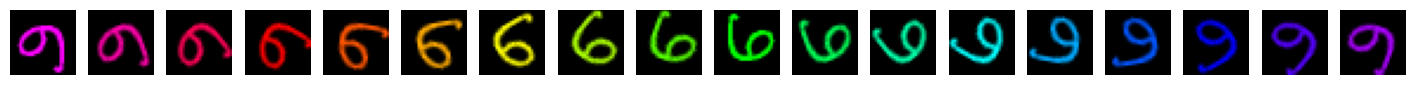

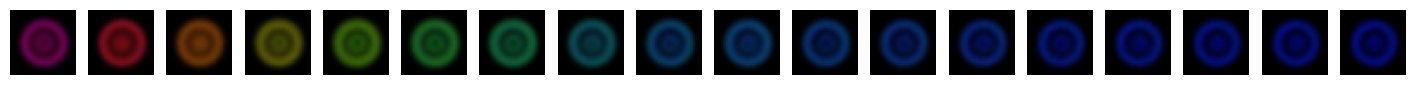

Reconstruction loss: 45.29136276245117


In [61]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cuda')
lldm = lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

idx = torch.randint(0, len(train_dataset), (1,)).item()
x = train_dataset[idx]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 0)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec.unsqueeze(0))

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [62]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cuda')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 18, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)

torch.Size([8000, 18, 12])


PCA on the whole dataset (144000 data points)


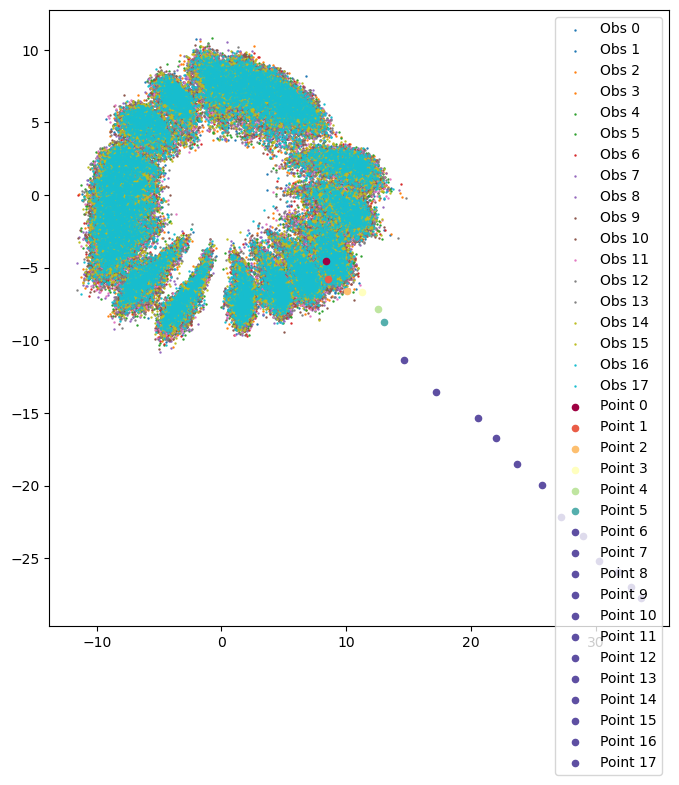

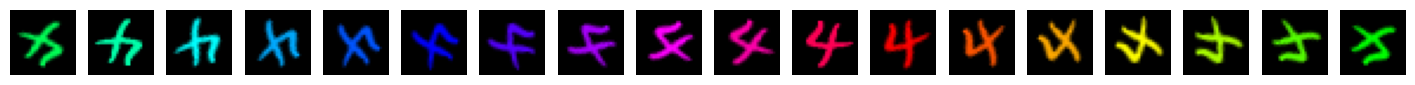

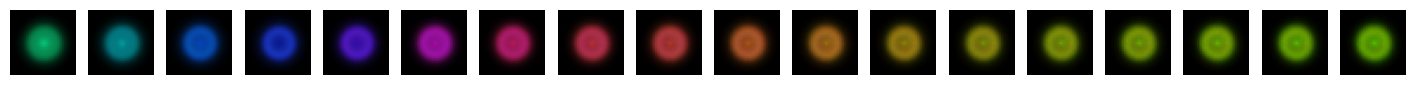

Reconstruction loss: 36.58014678955078


In [63]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
lldm = lldm.to('cuda')
#torch.manual_seed(46)

###################
vi_index = 2
projection_index = 'all' # 'all', 'pre
displayed_indexes = range(num_obs)  #range(num_obs)
train_point = 1169
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
elif projection_index == 'pre':
    last_preembed = torch.load('preembedding-last.pt')
    #last_preembed = torch.load('pre-embeddings2.pt')
    #last_preembed = torch.load('pre-embeddings-priordecalee.pt')
    pca.fit(last_preembed)
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)



plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]

z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

sampler = lldm.ddim_sampler
start = train_embeddings[train_point, vi_index, :].cuda().reshape(1, model.c, model.h, model.w)
_, z_seq, _ = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
z_seq = z_seq[:-1].reshape(-1, latent_dim)
x_rec = lldm.decoder(z_seq).reconstruction


z_seq_pca = pca.transform(z_seq.cpu().detach())

colors = plt.get_cmap('Spectral', 7)
for i in range(num_obs):
    plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')


plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec.unsqueeze(0))

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [49]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
new_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)

last_train_data = train_data[:, -1]
last_eval_data = eval_data[:, -1]


BATCH_SIZE = 256

last_train_loader = torch.utils.data.DataLoader(last_train_data, batch_size=BATCH_SIZE, num_workers = 12)
last_val_loader = torch.utils.data.DataLoader(last_eval_data, batch_size=800, num_workers = 12)


In [50]:
import lightning as L
ldm = lldm.pretrained_ldm

#UNFREEZE LDM
for p in ldm.parameters():
    p.requires_grad = True


n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 1e-3
MAX_EPOCHS = 100


model = LitLDM(ldm = ldm, vae = new_vae, lr = lr).to(device)




trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm_retrain', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, last_train_loader, last_val_loader)

#REFREEZE LDM
for p in ldm.parameters():
    p.requires_grad = False

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/eleves-a/2020/meilame.tayebjee/miniconda3/lib ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 12GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ldm_retrain/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


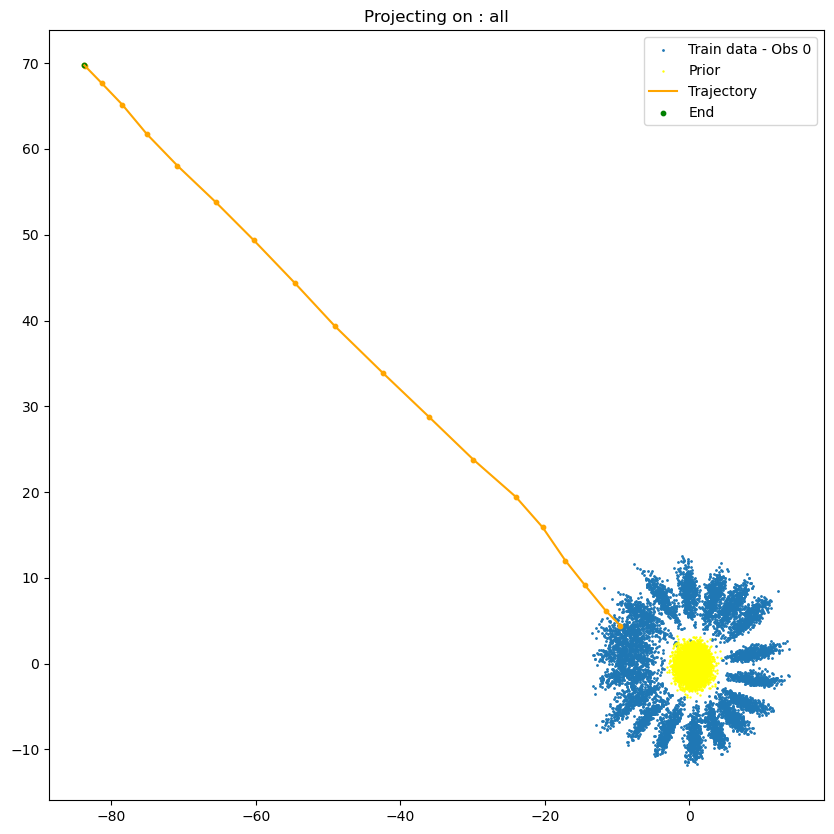

In [41]:
sampler = lldm.ddim_sampler
lldm = lldm.to('cuda')
lldm.eval()

######################
check_index = 0 #6
start = 'embedding' #'embedding'
######################

assert check_index == 6 or check_index == 0
assert start == 'normal' or start == 'embedding'
if check_index == 0:
    check = np.random.randn(10000, model.lat_dim)
if check_index == 6:
    check = last_preembed


check_pca = pca.transform(check)

if start == 'normal':
    start = torch.randn(1, model.c, model.h, model.w).to('cuda')
if start == 'embedding':
    start = train_embeddings[train_point, 0, :].reshape(1, model.c, model.h, model.w).to('cuda')

z, all_z, all_pred_z0 = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)

z = z.reshape(-1, latent_dim).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 28, 28)


all_z = all_z.squeeze(1).reshape(-1, latent_dim)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 28, 28)

start = start.reshape(-1, latent_dim).float()



all_z_pca = pca.transform(all_z.detach().cpu().numpy())
start_pca = pca.transform(start.detach().cpu().numpy())
z_pca = pca.transform(z.detach().cpu().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(train_embeddings_pca[:, check_index, 0], train_embeddings_pca[:, check_index, 1], label=f'Train data - Obs {check_index}', s= 1)
plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Prior', s= 0.5, c = 'yellow')

# old = torch.load('preembedding-last.pt')
# #old = torch.load('pre-embeddings-priordecalee.pt')
# old_pca  = pca.transform(old)

#plt.scatter(old_pca[:, 0], old_pca[:, 1], label='Previous Obs 6 embed.', s= 0.5, c = 'red')


plt.plot(all_z_pca[:, 0], all_z_pca[:, 1], label='Trajectory', c = 'orange')
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], c = 'orange', s=10)
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=10, label = "End", c = 'green')
plt.legend()
plt.title('Projecting on : ' + str(projection_index))
plt.show()

/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


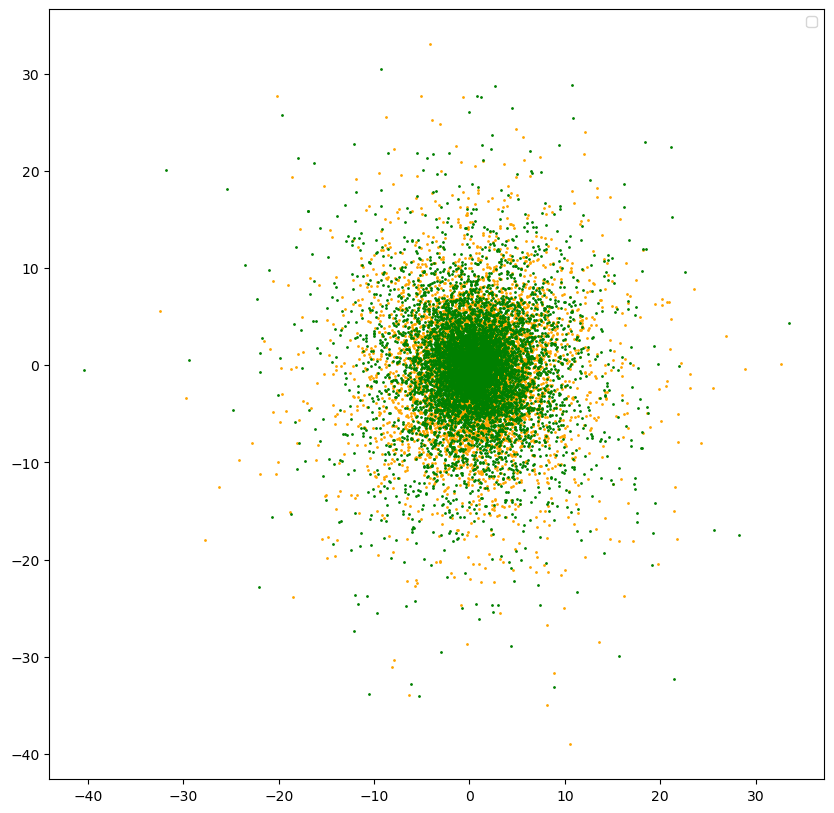

In [42]:
NUM_POINTS = 10000

INDEX = -1

sampler = lldm.ddim_sampler
z = torch.randn(NUM_POINTS, latent_dim).to('cuda')

_, final_z_1, _ = sampler.sample(shape = (NUM_POINTS, 3, 2, 2), x_last = z.reshape(NUM_POINTS, 3, 2, 2), cond = None)
final_z_1  = final_z_1[INDEX, :, :, :, :].reshape(-1, latent_dim)

z_vi_index = z
z_seq = [z_vi_index]

z_for = z_vi_index
batch_size = z_for.shape[0]
vi_index = 0
for i in range(vi_index, lldm.n_obs - 1):
    t = torch.tensor(lldm.diff_t_steps[i]).reshape(1).to(lldm.pretrained_ldm.device).float() #diffusion time-step
    z_for = z_for.reshape(batch_size, lldm.pretrained_ldm.c, lldm.pretrained_ldm.h, lldm.pretrained_ldm.w).float().to(lldm.pretrained_ldm.device)
    noise_pred = lldm.pretrained_ldm(z_for, t) # \eps_\theta (z_t, t)
    z_for, _ = sampler.get_x_prev_and_pred_x0(e_t = noise_pred,
                                                        index = lldm.n_obs -1- i,
                                                        x = z_for,
                                                        temperature=lldm.temperature,
                                                        repeat_noise=False)
    
    z_for = z_for.reshape(batch_size, lldm.pretrained_ldm.c * lldm.pretrained_ldm.h * lldm.pretrained_ldm.w).to(lldm.pretrained_ldm.device)
    z_seq.append(z_for)



z_seq = torch.stack(z_seq, dim = 1)

final_z_2 = z_seq[:, INDEX, :].reshape(-1, latent_dim)

z_pca = pca.transform(z.detach().cpu().numpy())
final_z_pca = pca.transform(final_z_1.detach().cpu().numpy())
final_z_pca_2 = pca.transform(final_z_2.detach().cpu().numpy())

plt.figure(figsize=(10, 10))
#plt.scatter(z_pca[:, 0], z_pca[:, 1], label='Prior', s= 0.5, c = 'yellow')

plt.scatter(final_z_pca[:, 0], final_z_pca[:, 1], c = 'orange', s=1)
plt.scatter(final_z_pca_2[:, 0], final_z_pca_2[: ,1], c = 'green', s=1)
#plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Prior', s= 1, c = 'yellow')
plt.legend()

In [20]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
final_vae = VAE(model_config = model_config, encoder = lldm.encoder, decoder = lldm.decoder)
obs_data = train_data[:, 0]
_, mu, log_var = final_vae.retrieveG(obs_data, verbose = True, T_multiplier=0.5, device = 'cuda', addStdNorm=False)






Running Kmedoids
Finding temperature
Best temperature found:  8.50917911529541
Building metric
Increasing T by  0.5


In [28]:
n_samples = 10
batch_size = 10
all_z0 = []

device = 'cpu'
final_vae = final_vae.to(device)
mu = mu.to(device)
for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(final_vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z0.append(z)

p = p[0]
all_z0 = torch.cat(all_z0, dim=0).cpu().detach()
all_z0.shape

torch.Size([10, 12])

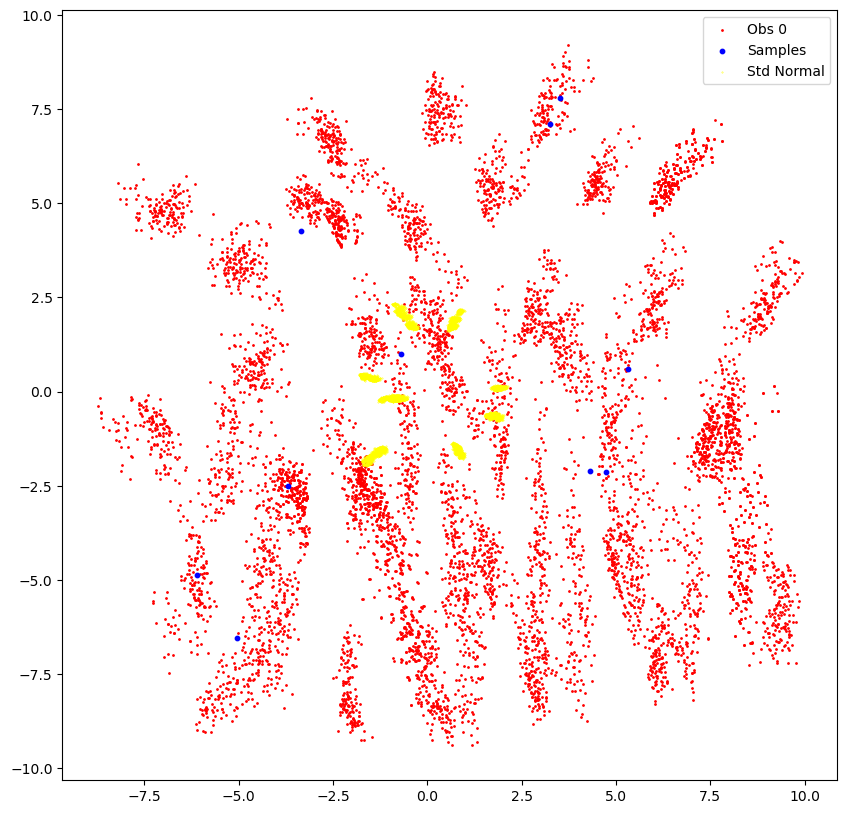

In [29]:
final_vae = final_vae.to(obs_data.device)
obs_manifold = final_vae.encoder(obs_data).embedding.cpu().detach().numpy()
obs_manifold_pca = pca.transform(obs_manifold.reshape(-1, latent_dim))
all_z0_pca = pca.transform(all_z0.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(obs_manifold_pca[:, 0], obs_manifold_pca[:, 1], label='Obs 0', s= 1, c = 'red')
plt.scatter(all_z0_pca[:, 0], all_z0_pca[:, 1], label='Samples', s= 10, c = 'blue')
plt.scatter(check_pca[:, 0], check_pca[:, 1], label='Std Normal', s= 0.1, c = 'yellow')
plt.legend()
plt.show()

In [30]:
all_z0 = all_z0.to('cuda')
NUM_OBS = train_data.shape[1]
all_sequences = lldm.ddim_sampler.sample(shape=(all_z0.shape[0], model.c, model.h, model.w), x_last = all_z0.reshape(-1, model.c, model.h, model.w), temperature = 1)[1]
all_sequences = all_sequences[:-1].transpose(0, 1).reshape(all_z0.shape[0], NUM_OBS, latent_dim).cpu()
all_sequences.shape

torch.Size([10, 7, 12])

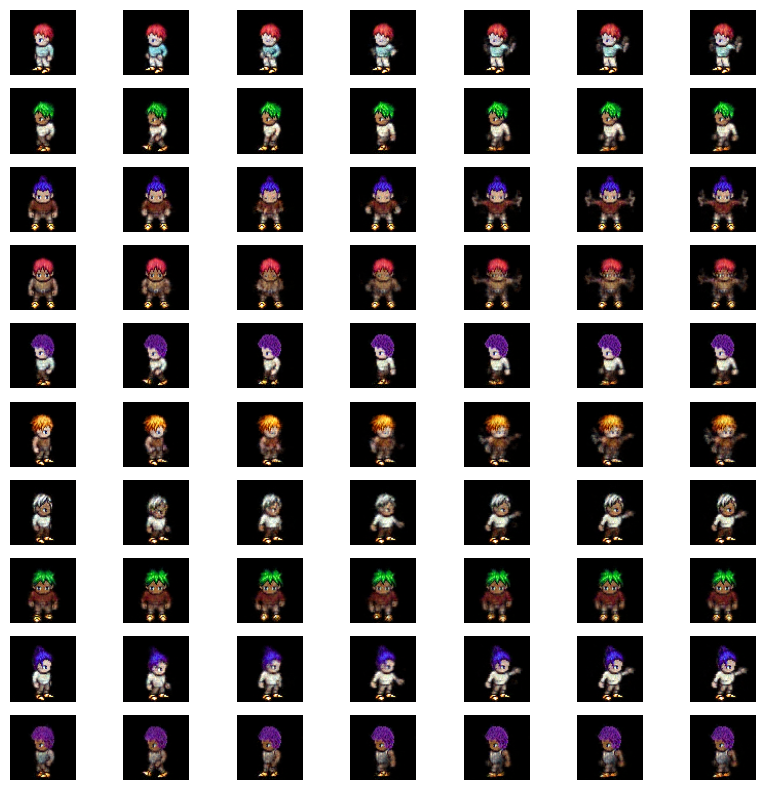

In [31]:
recon = final_vae.decoder(all_sequences.reshape(-1, latent_dim)).reconstruction.reshape(-1, NUM_OBS, 3, 64, 64)
plot_sequence(recon)

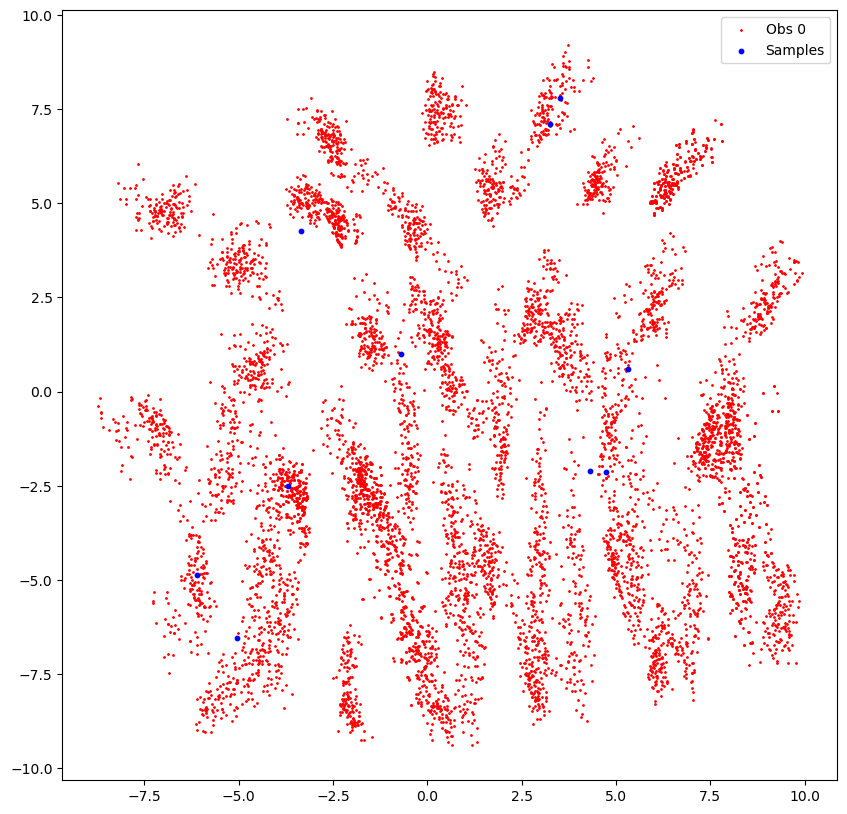

In [32]:
obs_manifold = final_vae.encoder(obs_data).embedding.cpu().detach().numpy()
obs_manifold_pca = pca.transform(obs_manifold.reshape(-1, latent_dim))
all_z0_pca = pca.transform(all_z0.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(obs_manifold_pca[:, 0], obs_manifold_pca[:, 1], label='Obs 0', s= 1, c = 'red')
plt.scatter(all_z0_pca[:, 0], all_z0_pca[:, 1], label='Samples', s= 10, c = 'blue')
plt.legend()
plt.show()

Running Kmedoids
Finding temperature
Best temperature found:  120.40079498291016
Building metric
Increasing T by  0.5
Sampling on the 4th/rd manifold...
Propagating in the past...
Propagating in the future...
Decoding...


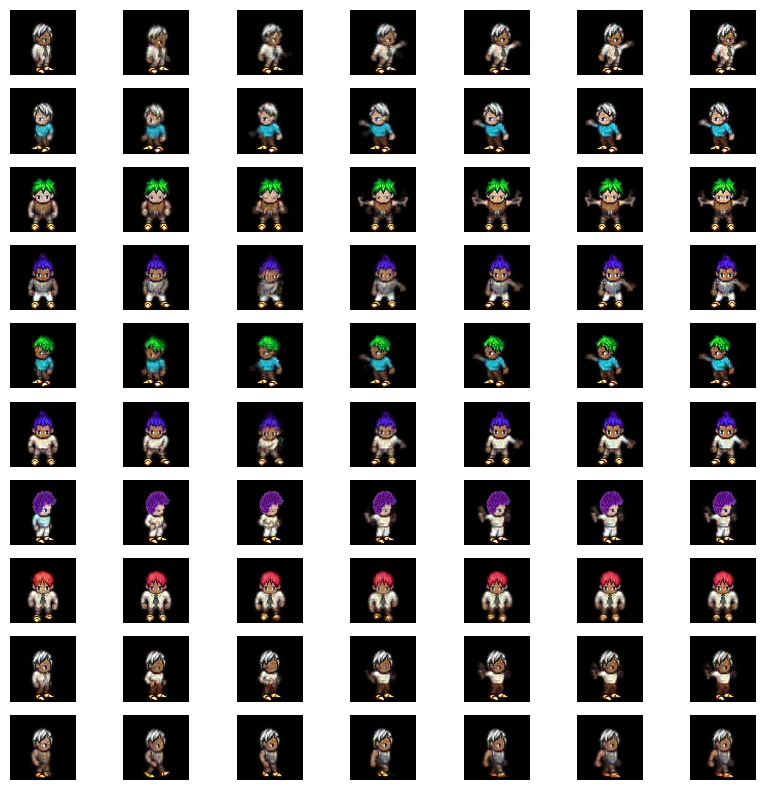

In [34]:
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=10, vi_index = 4)
plot_sequence(recon_x)

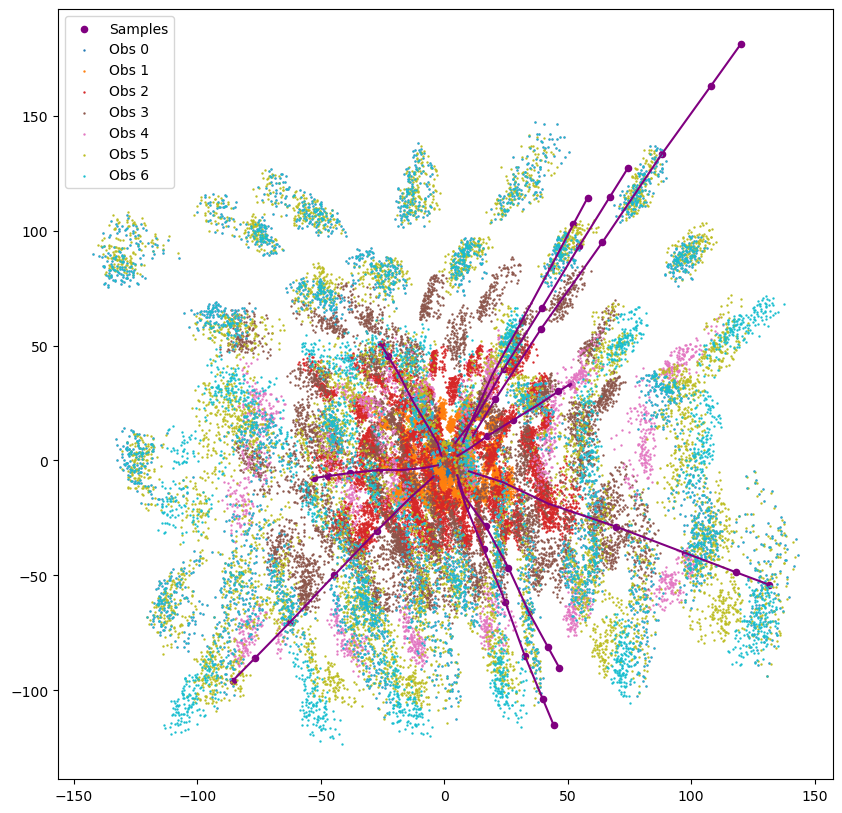

In [35]:
displayed_indexes = range(num_obs)  #range(num_obs)

all_sequences = z_seq
all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
all_sequences_pca = all_sequences_pca.reshape(n_samples, NUM_OBS, 2)
plt.figure(figsize=(10, 10))
plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

for i in range(n_samples):
    plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


plt.legend()
